In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
mpl.rcParams["mathtext.fontset"] = "stix"
from scipy.stats import combine_pvalues

In [3]:
%run -i 'load_data.py'

In [4]:
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import rpy2
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as rpyn
from statsmodels.stats.multitest import multipletests
dt = rpy2.robjects.packages.importr('diptest')

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.special import logit
from scipy.special import expit

from sklearn.metrics import adjusted_rand_score

from scipy.stats import chisquare

from scipy.stats import hypergeom
def hyper_test(M, n, N, k):
    
    hpd = hypergeom(M, n, N)
    p_depleted = hpd.cdf(k)
    p_enriched = hpd.sf(k-1)
    
    return p_depleted, p_enriched


from scipy.stats import probplot

In [5]:
np.nan

nan

In [6]:
def test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
#     run_test = True
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
#         if (pos_cases == 0) and (neg_cases == 0):#
# #             run_test = False#

#         if (pos_cases + neg_cases) < 10:
#             run_test = False
            
#     if (np.sum(chi_pos) < 10) or (np.sum(chi_neg) < 10):#
#         run_test = False#
        
#     if not run_test:#
#         chip = np.nan#
#     else:#
    chip = chisquare(chi_pos, chi_exp)[1]#
        
    return chip, np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)#


def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads, chi_p_reads = cluster_chi_test(aver_all_reads[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
        
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    joint_idx = change_tab.index
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
#         print(list(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals']))
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
    
    else:
        
        
        
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([-0.05, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(change_tab.shape)
    
    N = len([x for x in aver[0].index if x in change_tab.index])
    k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
        k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in change_tab.index])
        k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
27


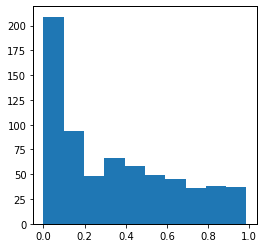

(680, 6)


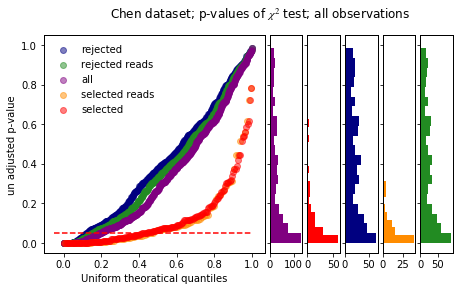

(680, 6)
filter
680
131
157
66
(0.9999999999991362, 9.348899643261109e-15)
reads
680
131
92
42
(0.9999999999405351, 2.909652460926646e-10)


In [7]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [8]:
# test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
#                      psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [9]:
# test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
#                      psi_min = 0.05, psi_bin = 0.25, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [10]:
# test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
#                      psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [11]:
# test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
#                      psi_min = 0.05, psi_bin = 0.25, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs=True, 
#                  dset_name = 'Chen dataset;')

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
581


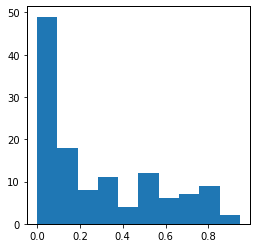

not pass
567


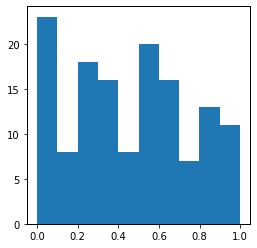

(126, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


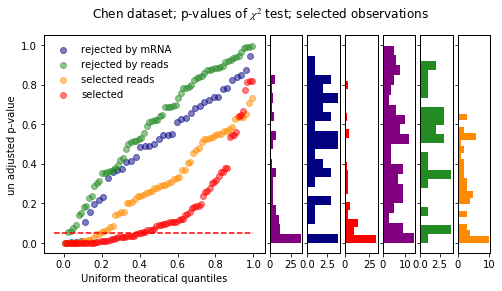

(126, 6)
filter
126
39
85
35
(0.9999733367687581, 0.00019118958112307376)
reads
140
14
68
13
(0.999981068880479, 0.0003658869101354098)


In [12]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs=True, 
                 dset_name = 'Chen dataset;')

492
(497, 513)
(611, 513)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
10


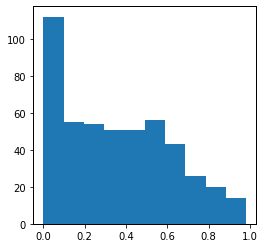

(482, 4)


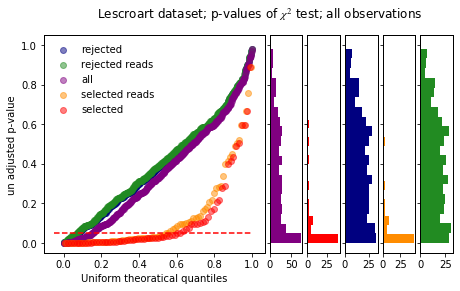

(482, 4)
filter
482
73
67
40
(1.0, 6.489545326911521e-21)
reads
482
73
82
44
(1.0, 8.112723158431036e-21)


In [13]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, 
                 lescroart_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Lescroart dataset;')

492
(497, 513)
(611, 513)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
292


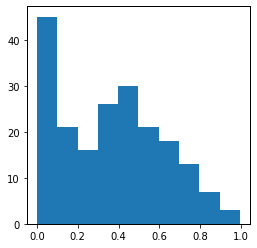

not pass
298


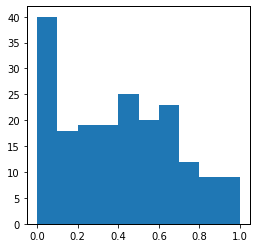

(200, 4)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


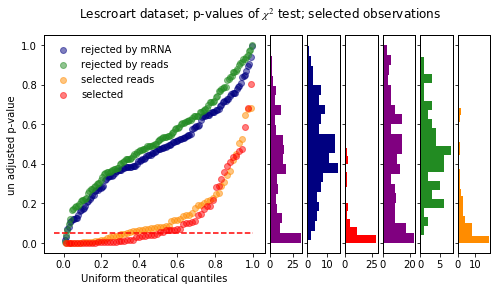

(200, 4)
filter
200
34
64
32
(0.9999999999999982, 5.752392750457643e-17)
reads
194
23
64
21
(0.9999999999741903, 8.575566360536249e-10)


In [14]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, 
                 lescroart_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs=True, 
                 dset_name = 'Lescroart dataset;')

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
21


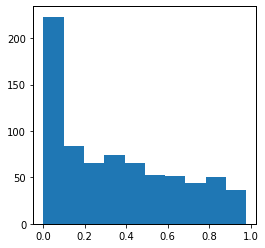

(746, 4)


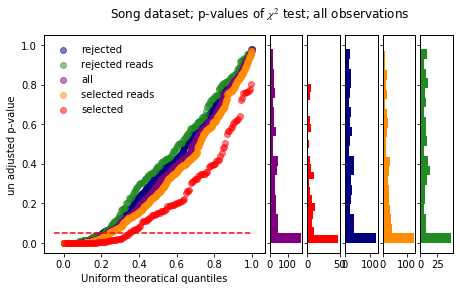

(746, 4)
filter
746
175
146
50
(0.9997025620708399, 0.0006221467803456282)
reads
746
175
540
130
(0.7689739221325559, 0.29450603584192325)


In [15]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10, dset_name = 'Song dataset;')

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
182


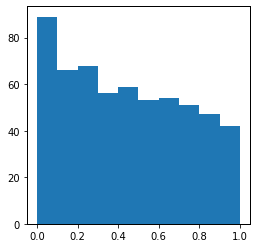

not pass
16


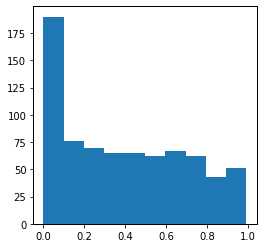

(585, 4)


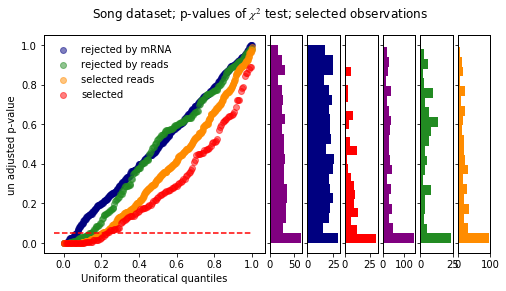

(585, 4)
filter
585
63
144
33
(0.999999903728899, 4.135873634391211e-07)
reads
751
144
541
113
(0.9798669291521832, 0.03322925351370645)


In [16]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10, filter_obs=True, dset_name = 'Song dataset;')

241
(241, 231)
(242, 231)
not pass
0


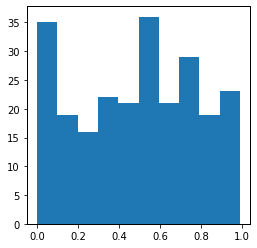

(241, 5)


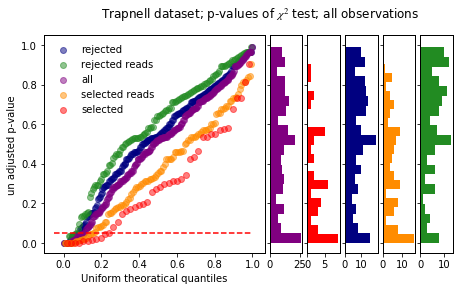

(241, 5)
filter
241
26
44
11
(0.9995343055849283, 0.002158251666432886)
reads
241
26
113
18
(0.995925255561197, 0.013279418650192729)


In [17]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                 trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 6, read_min =10, dset_name = 'Trapnell dataset;')

241
(241, 231)
(242, 231)
not pass
0


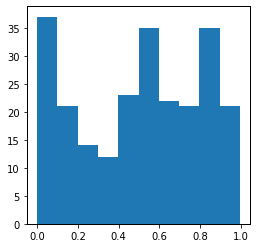

(241, 5)


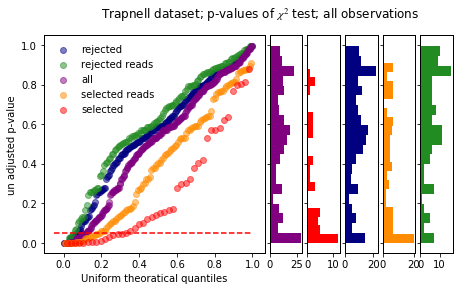

(241, 5)
filter
241
29
44
15
(0.999998552778137, 1.0751324038548351e-05)
reads
241
29
113
22
(0.9998369410150804, 0.0007555716771733699)


In [18]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                 trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 6, read_min =10, dset_name = 'Trapnell dataset;')

241
(241, 231)
(242, 231)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
26


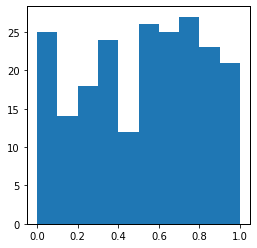

not pass
2


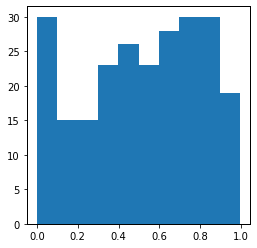

(215, 5)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


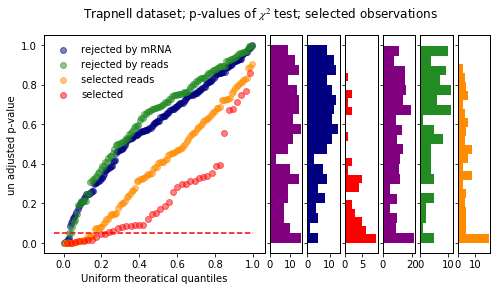

(215, 5)
filter
215
15
44
10
(0.999993735560289, 6.962272796610499e-05)
reads
239
21
113
18
(0.9999795420576557, 0.00017736296278552223)


In [19]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                 trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 6, read_min =10, filter_obs=True, 
                 dset_name = 'Trapnell dataset;')

In [20]:
import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')
m = np.array([[4,4],[4,5],[10,6]])
res = stats.fisher_test(m)
print ('p-value: {}'.format(res[0][0]))

p-value: 0.6643639131198411


In [21]:
def test_exon_bimodal_fisher(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
    
    run_test = True
    
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
        if (pos_cases == 0) and (neg_cases == 0):
            run_test = False
            
    if (np.sum(chi_pos) < 5) or (np.sum(chi_neg) < 5):
        run_test = False
            
    if not run_test:
        ftest_p = np.nan
        
    else:
        
        try:
            ftest_p = stats.fisher_test(np.array([chi_pos, chi_neg]))[0][0]
        except:
            ftest_p = np.nan
        
    return ftest_p, np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)


def cluster_fisher_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = False, 
                     print_extreme=False, extreme = 0.95):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_fisher(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    if correct_multitest:
        pvals_adj = multipletests(pvals, method=correction)[1]
    else:
        pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals_adj


def test_fisher_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
#     joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
#     if filter_obs:
#         change_tab, chi_p = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
#         change_tab_reads, chi_p_reads = cluster_chi_test(aver_all_reads[0].loc[joint_idx], clusters, psi_bin)
#         change_tab_reads['pvals'] = chi_p_reads
#     else:
#         change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
        
    if filter_obs:
        change_tab, chi_p = cluster_fisher_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads, chi_p_reads = cluster_fisher_test(aver_all_reads[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_fisher_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
#     change_tab = get_osm(chi_p, change_tab.index)
    joint_idx = change_tab.index
    
#     if filter_obs:
#         change_tab_reads = get_osm(chi_p_reads, change_tab_reads.index)
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
#     ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
#                      probplot(change_tab.pvals, dist='uniform')[0][1], 
#                      alpha = 0.5, c='purple', label='all')
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
#         print(list(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals']))
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
#     ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
#                      probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
#                      alpha = 0.5, c='navy', label='rejected')
    
    else:
        
        
        
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([-0.05, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(change_tab.shape)
    
    N = len([x for x in aver[0].index if x in change_tab.index])
    k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
        k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in change_tab.index])
        k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)


R[write to console]: Error in (function (x, y = NULL, workspace = 2e+05, hybrid = FALSE, hybridPars = c(expect = 5,  : 
  FEXACT error 7(location). LDSTP=18600 is too small for this problem,
  (pastp=49.2715, ipn_0:=ipoin[itp=186]=227, stp[ipn_0]=46.913).
Increase workspace or consider using 'simulate.p.value=TRUE'



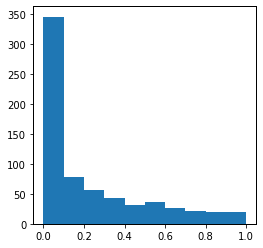

(678, 6)


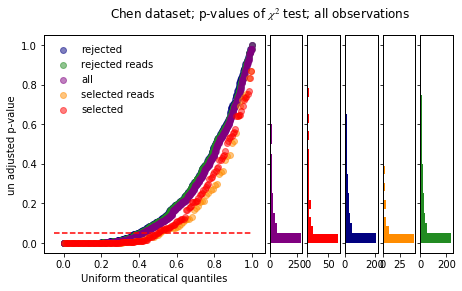

(678, 6)
filter
678
284
153
76
(0.9893531104174887, 0.017091304761542633)
reads
678
284
89
46
(0.9827668176498356, 0.029616575060126854)


In [22]:
test_fisher_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

767
(767, 202)
(778, 202)


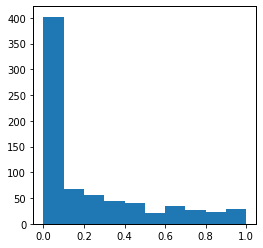

(744, 4)


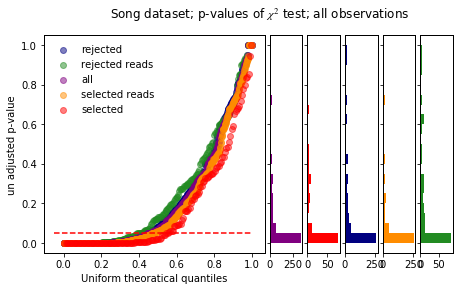

(744, 4)
filter
744
336
144
78
(0.9939056351118346, 0.010152968369223156)
reads
744
336
538
253
(0.958826672376525, 0.05801434254123973)


In [23]:
test_fisher_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10, dset_name = 'Song dataset;')

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
581


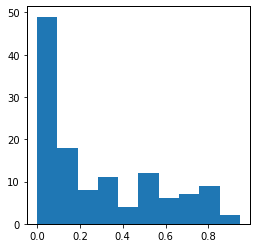

not pass
567


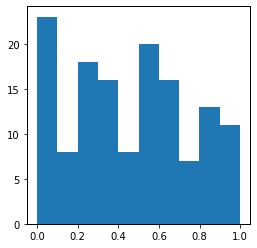

(126, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


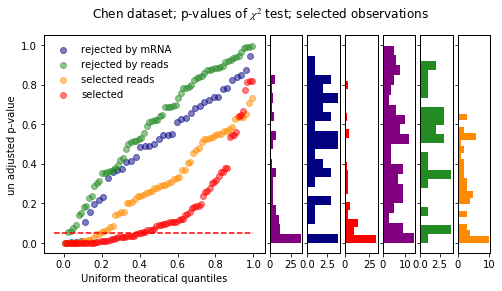

(126, 6)
filter
126
39
85
35
(0.9999733367687581, 0.00019118958112307376)
reads
140
14
68
13
(0.999981068880479, 0.0003658869101354098)


In [24]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs=True, 
                 dset_name = 'Chen dataset;')


In [25]:
m = np.array([[10,5,5,4],[0,0, 0, 0]])
res = stats.fisher_test(m)
print ('p-value: {}'.format(res[0][0]))

p-value: 1.0


In [26]:
chisquare([10, 10, 11, 22, 14], [0.84478022, 0.84478022, 1,         1.68956044, 0.84478022])

Power_divergenceResult(statistic=747.449917163681, pvalue=1.8493766017843807e-160)

In [27]:
# Hypergeom; bimodal
# Select antes y despues
# Fisher for p values
# Hypergeom + Fisher
# Filter only with min pos and neg obs

In [28]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    
    joint_idx = [x for x in int_exons if x in aver[0].index]
    print(len(joint_idx))
    
    print(aver[0].shape)
    change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    change_tab_aver, chi_p_aver = cluster_chi_test(aver[0].loc[joint_idx], clusters, psi_bin)
    
    change_tab_aver['pvals'] = chi_p_aver  
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    joint_idx = [x for x in change_tab.index if x in change_tab_aver.index]
    change_tab = change_tab.loc[joint_idx]
    change_tab_aver = change_tab_aver.loc[joint_idx]
    
    figsize(8, 4)
    fig = plt.figure()
    
    fig.suptitle(dset_name + ' p-values of $\chi^2$ test; selected observations')
    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))

        
    ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='unfiltered')
                
    ax_joint.scatter(probplot(change_tab_aver.pvals, 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_aver.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        
    ax_joint.plot([-0.05, 1], [0.05, 0.05], 'r--')
    
#     if filter_obs:
    ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
    ax_marg_x2.hist(change_tab_aver.pvals, 
                        orientation="horizontal", color='navy', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
#     M = len(chi_p)
#     n = np.sum([x <= 0.05 for x in chi_p])
    
#     print(change_tab.shape)
    
#     N = len([x for x in aver[0].index if x in change_tab.index])
#     k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
#     print('filter')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
#     if filter_obs:
#         M = len(chi_p_reads)
#         n = np.sum([x <= 0.05 for x in chi_p_reads])

#         N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
#         k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
#     else:
#         M = len(chi_p)
#         n = np.sum([x <= 0.05 for x in chi_p])

#         N = len([x for x in aver_reads[0].index if x in change_tab.index])
#         k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

#     print('reads')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))

158
(158, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
1


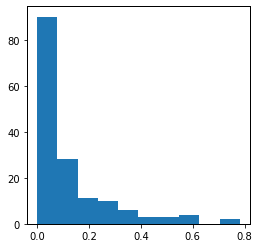

not pass
73


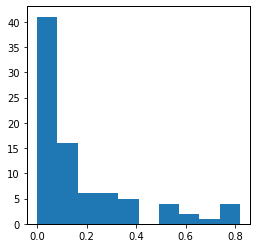

(157, 6)


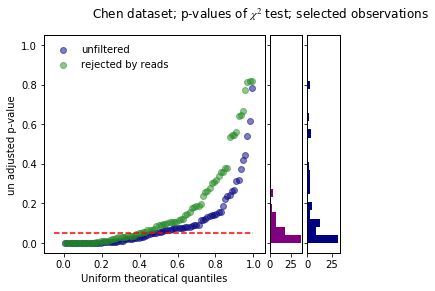

In [29]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [30]:
def test_exon_bimodal_hypergeom(PSI_tab, exon, clusters, psi_lim = 0.25, only_enrichment = False):
    
    psi_mean = PSI_tab.loc[exon].mean()
    
    run_test = True

    M = (PSI_tab.loc[exon] >= (1-psi_lim)).sum() + (PSI_tab.loc[exon] <= (psi_lim)).sum()
    n = (PSI_tab.loc[exon] >= (1-psi_lim)).sum()
    
    pvals = []
    hyp_pos = []
    hyp_neg = []
    
    ### Next: enrichment of only 1, or only 0; or both independently; related to all observations
    
    # Also, test just enrichment, vs enrichment + depletion
    
#     run_test = True
    
    
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        N = pos_cases + neg_cases
        
        if N == 0:
            run_test = False
            pvals.append(np.nan)
        else:
            if only_enrichment:
                pvals.append(hyper_test(M, n, N, pos_cases)[1])
            else:
                pvals.extend(list(hyper_test(M, n, N, pos_cases)))
            
        hyp_pos.append(pos_cases)
        hyp_neg.append(neg_cases)
        
    if run_test:
        hyper_p = combine_pvalues(pvals)[1]
    else:
        hyper_p = np.nan
        
        
    return hyper_p, np.array(hyp_pos), np.array(hyp_neg)





def cluster_hypergeom_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg = test_exon_bimodal_hypergeom(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            

        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_hypergeom_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_hypergeom_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads, chi_p_reads = cluster_hypergeom_test(aver_all_reads[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_hypergeom_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
        
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    joint_idx = change_tab.index
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
    else:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([-0.05, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(change_tab.shape)
    
    N = len([x for x in aver[0].index if x in change_tab.index])
    k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
        k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in change_tab.index])
        k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)
not pass
27


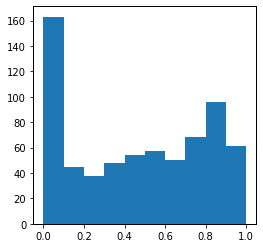

(680, 6)


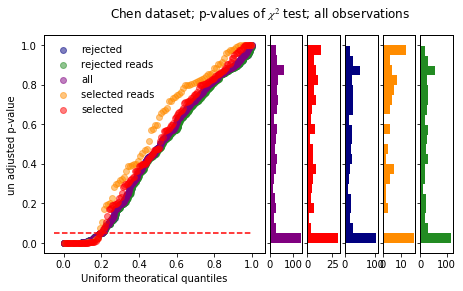

(680, 6)
filter
680
134
157
31
(0.5559548378083081, 0.5349826503857954)
reads
680
134
92
17
(0.4376746398351057, 0.6708336081460262)


In [31]:
test_hypergeom_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [32]:
def test_exon_bimodal_hypergeom(PSI_tab, exon, clusters, psi_lim = 0.25, only_enrichment = True):
    
    psi_mean = PSI_tab.loc[exon].mean()
    
    run_test = True

    M = (~PSI_tab.loc[exon].isna()).sum()
    
    n_pos = (PSI_tab.loc[exon] >= (1-psi_lim)).sum()
    n_neg = (PSI_tab.loc[exon] <= psi_lim).sum()
    
    if (n_neg <= 10) or (n_pos <= 10):
        print('reject, not enough pos or neg in general')
        run_test = False
    
    pvals = []
    hyp_pos = []
    hyp_neg = []
    
    ### Next: enrichment of only 1, or only 0; or both independently; related to all observations
    
    # Also, test just enrichment, vs enrichment + depletion
    
#     run_test = True
    
    
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        N = (~PSI_tab.loc[exon, cluster_cells].isna()).sum()
        
        if (pos_cases + neg_cases) < 1:
            print('reject, small cluster')
            run_test = False
            pvals.append(np.nan)
        else:
            if only_enrichment:
                pvals.append(hyper_test(M, n_pos, N, pos_cases)[1])
                pvals.append(hyper_test(M, n_neg, N, neg_cases)[1])
            else:
                pvals.extend(list(hyper_test(M, n_pos, N, pos_cases)))
                pvals.extend(list(hyper_test(M, n_neg, N, neg_cases)))
            
        hyp_pos.append(pos_cases)
        hyp_neg.append(neg_cases)
        
    if run_test:
        hyper_p = combine_pvalues(pvals)[1]
    else:
        hyper_p = np.nan
        
    if (hyper_p >= 0.99) or (hyper_p <= 0.01):
        print(hyper_p)
        print(M)
        print(hyp_pos)
        print(hyp_neg)
        
    return hyper_p, np.array(hyp_pos), np.array(hyp_neg)





def cluster_hypergeom_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg = test_exon_bimodal_hypergeom(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            

        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_hypergeom_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_hypergeom_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads, chi_p_reads = cluster_hypergeom_test(aver_all_reads[0].loc[joint_idx], clusters, psi_bin)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_hypergeom_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
        
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    joint_idx = change_tab.index
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
    else:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([-0.05, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(change_tab.shape)
    
    N = len([x for x in aver[0].index if x in change_tab.index])
    k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
        k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in change_tab.index])
        k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, small cluster
1.7078176818103302e-05
345
[82, 23, 37, 5, 2]
[23, 15, 17, 20, 11]
0.007738794374295574
269
[97, 34, 47, 6, 6]
[14, 6, 3, 11, 2]
3.7059464849492283e-06
299
[59, 17, 25, 1, 1]
[42, 18, 24, 23, 16]
0.00026016866126163797
334
[73, 21, 38, 4, 2]
[27, 17, 19, 20, 10]
0.003735236527378179
228
[76, 30, 35, 4, 4]
[17, 8, 4, 12, 5]
0.007931846987499774
412
[24, 6, 14, 4, 0]
[75, 36, 26, 18, 9]
reject, small cluster
reject, small cluster
1.5263722332089604e-10
280
[24, 4, 5, 2, 21]
[80, 31, 55, 23, 0]
4.964416637100399e-12
269
[14, 4, 4, 2, 21]
[85, 35, 54, 24, 0]
2.7815407896954137e-14
397
[105, 16, 17, 6, 1]
[12, 18, 23, 16, 5]
0.006367694379126975
417
[67, 29, 29, 12, 5]
[17, 4, 3, 1, 10]
1.0466754288460116e-07
312
[46, 35, 7, 2, 2]
[19, 7, 14, 9, 2]
1.7259282627106038e-07
226
[70, 15, 22, 11, 2]
[11, 20, 23, 3, 1]
1.284846904748609e-06
163
[14, 10, 6, 4, 20]
[2

0.0010763375109638408
147
[7, 10, 42, 20, 3]
[1, 2, 0, 3, 9]
2.281637305000107e-05
310
[45, 39, 33, 4, 7]
[33, 9, 14, 15, 0]
0.006826248411166823
453
[98, 40, 30, 12, 3]
[4, 3, 7, 8, 4]
0.008808545865481835
303
[37, 17, 29, 8, 0]
[41, 21, 15, 5, 5]
3.11045146253979e-07
478
[17, 6, 6, 8, 15]
[9, 3, 2, 3, 0]
reject, not enough pos or neg in general
0.00021377517151215794
403
[29, 8, 21, 8, 0]
[41, 18, 30, 10, 10]
reject, not enough pos or neg in general
6.075250885734284e-10
446
[71, 33, 24, 3, 0]
[12, 7, 22, 23, 12]
6.904413347232727e-06
418
[116, 55, 51, 13, 6]
[5, 5, 6, 14, 7]
5.675729609548089e-05
423
[13, 8, 11, 13, 5]
[97, 37, 16, 17, 6]
0.0004259877487535836
282
[67, 40, 46, 13, 6]
[9, 7, 3, 2, 5]
0.00039194229147636957
415
[100, 38, 41, 10, 4]
[5, 2, 11, 8, 6]
0.00013538477213887322
288
[53, 12, 8, 6, 1]
[44, 29, 45, 17, 8]
8.579277902517142e-07
318
[76, 18, 9, 6, 1]
[34, 26, 39, 13, 8]
9.963186607269283e-09
254
[54, 5, 5, 1, 2]
[49, 10, 41, 22, 0]
reject, not enough pos or neg i

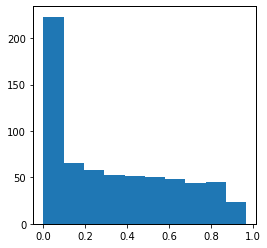

(661, 6)


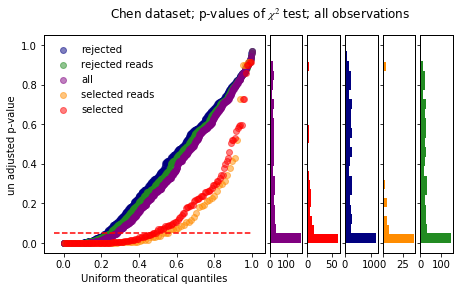

(661, 6)
filter
661
186
138
66
(0.9999999936971808, 2.0087334855890947e-08)
reads
661
186
73
39
(0.9999996832099569, 1.1463365960425042e-06)


In [33]:
test_hypergeom_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

1913
(1967, 488)
(2081, 488)
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
1.7078176818103302e-05
345
[82, 23, 37, 5, 2]
[23, 15, 17, 20, 11]
0.007738794374295574
269
[97, 34, 47, 6, 6]
[14, 6, 3, 11, 2]
3.7059464849492283e-06
299
[59, 17, 25, 1, 1]
[42, 18, 24, 23, 16]
0.00026016866126163797
334
[73, 21, 38, 4, 2]
[27, 17, 19, 20, 10]
0.003735236527378179
228
[76, 30, 35, 4, 4]
[17, 8, 4, 12, 5]
0.007931846987499774
412
[24, 6, 14, 4, 0]
[75, 36, 26, 18, 9]
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
rej

reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.0009295507620581799
380
[42, 27, 14, 8, 2]
[53, 16, 21, 8, 15]
reject, not enough pos or neg in general
2.2113324327141244e-06
155
[7, 2, 0, 0, 12]
[69, 25, 24, 6, 1]
2.6516576845263574e-08
346
[3, 1, 0, 0, 9]
[138, 65, 82, 23, 0]
reject, not enough pos or neg in general
0.0006554331583566444
265
[73, 15, 38, 16, 10]
[21, 23, 13, 12, 0]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough 

reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.0008374391707040606
311
[68, 31, 22, 7, 2]
[23, 18, 29, 16, 6]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
4.589895533840902e-05
223
[3, 0, 1, 12, 0]
[94, 40, 37, 16, 5]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.0076968880092591575
312
[36, 13, 16, 12, 0]
[56, 27, 23, 15, 18]
reje

reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.00011903036238055717
414
[3, 0, 1, 0, 7]
[137, 75, 91, 37, 2]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, not enough pos or neg in general
0.006038989968873796
277
[29, 10, 7, 0, 2]
[60, 33, 47, 19, 8]
reject, not enough pos or neg in general
0.00024269467313271456
328
[46, 12, 24, 7, 8]
[23, 5, 7, 0, 0]
0.00010990850116481924
357
[57, 18, 33, 7, 11]
[13, 2, 6, 0, 0]
reject, not enough pos or neg in general
0.0021232419681681044
233
[7, 1, 2, 8, 3]
[97, 35, 48, 9, 7]
7.473293675989188e-05
211
[29, 27, 12, 5, 11]
[47, 7, 22, 9, 0]
reject, not enough pos

0.00925377637592153
351
[7, 2, 11, 4, 5]
[119, 54, 59, 19, 6]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.005993525185974167
408
[10, 4, 1, 4, 5]
[100, 44, 67, 22, 2]
reject, not enough pos or neg in general
0.0006780999429229764
241
[59, 39, 55, 5, 10]
[8, 9, 1, 12, 1]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, small cluster
reject, small cluster
reject, small cluster
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.002369387045950835
209
[16, 8, 18, 6, 7]
[74, 28, 24, 4, 2]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general


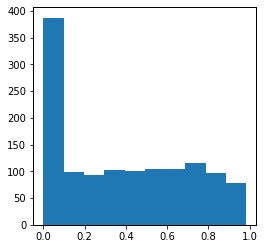

(1282, 6)


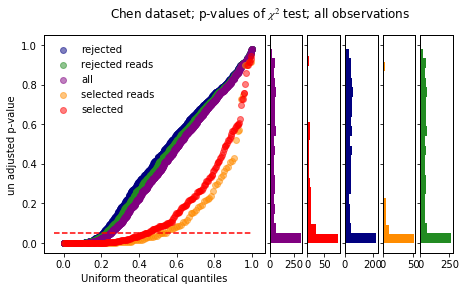

(1282, 6)
filter
1282
319
217
94
(0.9999999999863342, 3.8384090264981e-11)
reads
1282
319
100
52
(0.9999999997296838, 1.0382074846438761e-09)


In [34]:
test_hypergeom_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.05, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

739
(739, 202)
(778, 202)
reject, not enough pos or neg in general
1.334446942493317e-13
70
[0, 16, 19]
[26, 8, 0]
3.3457405481514666e-06
60
[3, 4, 14]
[21, 16, 1]
1.0936322288701168e-07
55
[0, 2, 12]
[20, 18, 2]
0.0013155083596654812
86
[1, 11, 9]
[31, 11, 15]
6.111538104461285e-07
83
[33, 15, 7]
[2, 4, 16]
7.071420605234146e-06
80
[30, 14, 9]
[2, 4, 16]
1.769023592076641e-09
183
[3, 33, 16]
[1, 5, 22]
0.00023640110391796686
57
[7, 4, 14]
[10, 17, 1]
2.5948538980894004e-05
67
[1, 0, 14]
[9, 21, 12]
5.8462821461272945e-08
75
[1, 1, 20]
[21, 16, 11]
5.1289612826572674e-11
59
[1, 0, 23]
[8, 19, 4]
0.00016733079279631152
56
[14, 3, 1]
[6, 19, 12]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.0006041323836916705
74
[11, 0, 1]
[19, 19, 16]
3.3344256684096326e-05
117
[15, 14, 38]
[20, 14, 6]
7.959547801011886e-06
81
[19, 11, 6]
[1, 19, 19]
0.0027778496669328416
56
[9, 8, 11]
[21, 3, 2]
0.0002905945520294421
59
[7, 19, 0]
[14, 3, 5]
9.239876236762922e-15


reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
0.00023436000789040366
63
[5, 13, 19]
[15, 7, 1]
4.342598814207975e-06
94
[3, 12, 28]
[14, 20, 4]
5.985168870244392e-06
156
[0, 19, 19]
[43, 19, 18]
0.00458879692726197
92
[17, 19, 23]
[18, 9, 2]
5.117679228896717e-14
92
[0, 1, 17]
[38, 29, 3]
2.2478726639867208e-05
74
[32, 16, 3]
[2, 8, 10]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
0.0005704652769656979
151
[39, 45, 9]
[1, 7, 12]
0.00047705234113019023
151
[37, 44, 8]
[1, 7, 12]
3.8073747998813983e-05
145
[36, 36, 9]
[1, 8, 16]
0.0071317353987832505
116
[35, 15, 12]
[0, 10, 11]
0.00930934152117595
116
[33, 16, 12]
[0, 10, 11]
4.3285431446024206e-08
115
[25, 14, 9]
[1, 6, 23]
4.704099468187265e-07
188
[0, 3, 22]
[28, 40, 23]
reject, not enough pos or neg in general
1.2733799167973673e-08
55
[0, 1, 14]
[13, 22, 3]
6.111775746290062e-

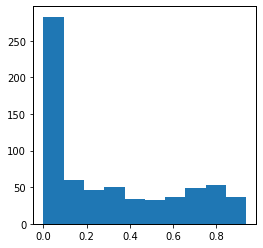

(681, 4)


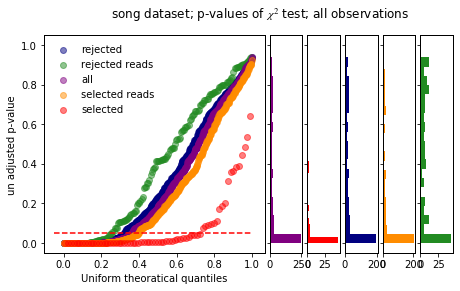

(681, 4)
filter
681
247
67
49
(0.9999999999812924, 1.0777913271472752e-10)
reads
681
247
513
204
(0.9997394389728574, 0.0005249550455140821)


In [35]:
test_hypergeom_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'song dataset;')

2510
(2510, 202)
(2633, 202)
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
1.797186735341773e-06
69
[0, 12, 1]
[36, 12, 8]
3.12486380912451e-07
68
[0, 12, 0]
[36, 12, 8]
reject, not enough pos or neg in general
1.334446942493317e-13
70
[0, 16, 19]
[26, 8, 0]
reject, not enough pos or neg in general
3.3457405481514666e-06
60
[3, 4, 14]
[21, 16, 1]
1.0936322288701168e-07
55
[0, 2, 12]
[20, 18, 2]
reject, not enough pos or neg in general
0.0013155083596654812
86
[1, 11, 9]
[31, 11, 15]
6.111538104461285e-07
83
[33, 15, 7]
[2, 4, 16]
7.071420605234146e-06
80
[30, 14, 9]
[2, 4, 16]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg 

reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.002902035526628281
178
[4, 12, 8]
[8, 22, 27]
0.00042310328985860774
176
[2, 12, 7]
[8, 24, 29]
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
1.2484353537312778e-16
68
[8, 21, 4]
[0, 1, 33]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, n

reject, not enough pos or neg in general
reject, not enough pos or neg in general
1.5724944908722883e-17
95
[0, 1, 22]
[35, 29, 5]
1.0556965518440409e-10
83
[1, 6, 15]
[29, 24, 1]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
2.3528024595551927e-22
185
[2, 14, 43]
[55, 44, 7]
reject, not enough pos or neg in general
reject, not enough pos or neg i

reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
2.3645708885240067e-05
152
[6, 38, 15]
[0, 9, 6]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
7.029403523556847e-07
177
[19, 40, 55]
[6, 6, 0]
reject, not enough pos or neg in general
reject, not enough pos or neg in general


reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.002652190724555591
83
[22, 5, 1]
[18, 18, 12]
reject, not enough pos or neg in general
1.1233205694504891e-10
54
[1, 16, 0]
[3, 4, 

reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
9.619900085927407e-06
94
[17, 3, 4]
[5, 13, 23]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, n

reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.0033387556361530496
63
[12, 3, 0]
[14, 12, 18]
0.0003035046390501019
71
[16, 5, 0]
[13, 11, 18]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.001808640240332309
180
[38, 42, 24]
[4, 5, 19]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
7.394831642717689e-13
166
[48, 60, 11]
[0, 3, 20]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
5.38823799493203e-23
154
[0, 4, 27]
[59, 48, 3]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enoug

reject, not enough pos or neg in general
5.117679228896717e-14
92
[0, 1, 17]
[38, 29, 3]
2.2478726639867208e-05
74
[32, 16, 3]
[2, 8, 10]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
r

reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, small cluster
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.000812986974859099
129
[13, 20, 6]
[8, 15, 18]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or n

0.0034008782867165042
154
[12, 33, 19]
[6, 11, 13]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.00023512792667812395
153
[16, 16, 6]
[5, 30, 24]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
6.760002317334206e-05
117
[25, 11, 25]
[2, 21, 13]
1.9499398533957676e-15
161
[2, 6, 32]
[46, 38, 6]
0.00012510336234714716
188
[2, 19, 28]
[0, 13, 10]
0.0012898246394277804
193
[7, 37, 33]
[0, 4, 8]
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
reject, not enough pos or neg in general
0.007322138799296081
76
[5, 13, 1]
[19, 11

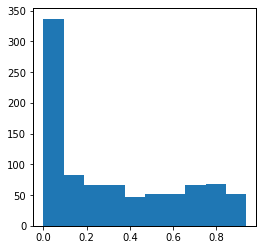

(886, 4)


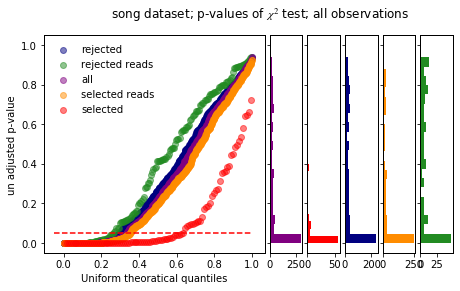

(886, 4)
filter
886
298
97
62
(0.9999999999782881, 9.303848198956615e-11)
reads
886
298
713
252
(0.9894380132692081, 0.01698422374090783)


In [36]:
test_hypergeom_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.05, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, dset_name = 'song dataset;')

In [37]:
combine_pvalues([1, 0.05, 0.05, 0.01, 0.99])

(21.213370137899147, 0.019653885069559132)

In [38]:
hyper_test(100, 10, 10, 0)

(0.3304762110867263, 1.0)

In [39]:
np.array([0, 0, 0.95, 0.99, 1, 0, np.nan, np.nan, 0]) <= 0.9

load_data.py:1: RuntimeWarning: invalid value encountered in less_equal
  import numpy as np


array([ True,  True, False, False, False,  True, False, False,  True])

In [40]:
9<np.nan

False

In [41]:
hyper_test(50, 30, 10, 0)

(1.7985883651357474e-05, 1.0)

In [42]:
1, 1, 0.003

(1, 1, 0.003)

In [43]:
spearmanr(np.arange(20), [0,0,0,0,0,0,np.nan,0,0,0,1,1,1,1,1,1,1,1,1,1])

SpearmanrResult(correlation=nan, pvalue=nan)

In [44]:
from numpy import cov

In [45]:
cov(np.arange(20), [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0])

array([[35.        ,  0.        ],
       [ 0.        ,  0.26315789]])

In [46]:
cov(np.arange(20), [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])

array([[35.        ,  2.63157895],
       [ 2.63157895,  0.26315789]])

In [47]:
from scipy.stats import kendalltau

In [48]:
kendalltau(np.arange(20), [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])

KendalltauResult(correlation=0.7254762501100116, pvalue=0.00015705228423075165)

In [49]:
kendalltau(np.arange(20), [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0])

KendalltauResult(correlation=0.0, pvalue=1.0)

In [50]:
from scipy.stats import pointbiserialr

In [51]:
pointbiserialr(np.arange(20), [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0])

PointbiserialrResult(correlation=-1.3877787807814457e-17, pvalue=0.9999999999999998)

In [52]:
def test_exon_bimodal_spearman(PSI_tab, exon, pca_clust, clusters = 'AC', psi_lim = 0.25, one_test = False):
    
#     print(psi_lim)
    
    if one_test:
    
        pos_cells = list(pca_clust.loc[PSI_tab.columns[PSI_tab.loc[exon] >= (1-psi_lim)], 'pseudotime'])
        neg_cells = list(pca_clust.loc[PSI_tab.columns[PSI_tab.loc[exon] <= psi_lim], 'pseudotime'])

        if (len(pos_cells) >= 5) and (len(neg_cells) >= 5):
            spearman_p = spearmanr(neg_cells + pos_cells, [0]*len(neg_cells) + [1]*len(pos_cells))[1]
        else:
            spearman_p = np.nan
            
    else:
        
        pvals = []
#         print('len')
#         print(len(pca_clust[clusters].unique()))
        for i in range(len(pca_clust[clusters].unique()) - 1):
            
            c1 = i
            c2 = i+1
            c1_cells = pca_clust.loc[pca_clust[clusters] == c1].index
            c2_cells = pca_clust.loc[pca_clust[clusters] == c2].index
            
            cluster_cells = list(c1_cells) + list(c2_cells)
            
            pos_cells = list(pca_clust.loc[PSI_tab[cluster_cells].columns[PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)], 
                                           'pseudotime'])
            neg_cells = list(pca_clust.loc[PSI_tab[cluster_cells].columns[PSI_tab.loc[exon, cluster_cells] <= psi_lim], 
                                           'pseudotime'])
            
            if (len(pos_cells) >= 5) and (len(neg_cells) >= 5):
                pvals.append(spearmanr(neg_cells + pos_cells, [0]*len(neg_cells) + [1]*len(pos_cells))[1])
#         print(len(pvals))
        if len(pvals) >= 2:
            spearman_p = combine_pvalues(pvals)[1]
        else:
            spearman_p = np.nan
        
    return spearman_p, len(pos_cells) + 1, len(neg_cells) + 1





def cluster_spearman_test(PSI_tab, pca_clust, clusters, psi_lim, correction = 'fdr_bh', 
                          correct_multitest = True, one_test = False):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg = test_exon_bimodal_spearman(PSI_tab, exon, pca_clust, clusters = 'AC', 
                                                     psi_lim = psi_lim, one_test = one_test)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            

        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame()
    cluster_df['array'] = cluster_array
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_spearman_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, pca_clust, clusters = 'AC',
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = '', one_test = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_spearman_test(aver_all[0].loc[joint_idx], pca_clust, clusters, 
                                                  psi_bin, one_test = one_test)
        change_tab_reads, chi_p_reads = cluster_spearman_test(aver_all_reads[0].loc[joint_idx], pca_clust, 
                                                              clusters, psi_bin, one_test = one_test)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_spearman_test(PSI_tab.loc[joint_idx], pca_clust, clusters, psi_bin, one_test = one_test)
        
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    joint_idx = change_tab.index
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of spearman test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of spearman test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
    else:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([0, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(change_tab.shape)
    
    N = len([x for x in aver[0].index if x in change_tab.index])
    k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
        k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in change_tab.index])
        k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

1913
(1967, 488)
(2081, 488)
not pass
649


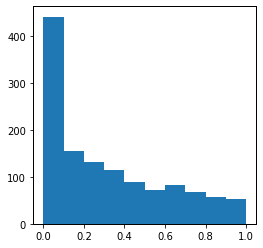

(1264, 2)


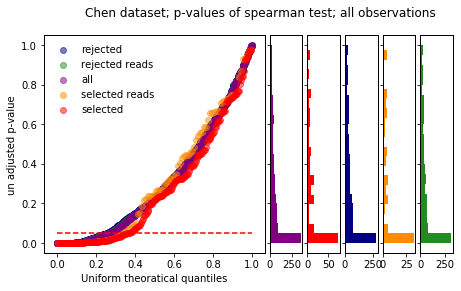

(1264, 2)
filter
1264
352
210
76
(0.9985625987202202, 0.00241123229303744)
reads
1264
352
97
33
(0.9347957561488509, 0.09937487109153698)


In [53]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, psi_bin = 0.1, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

1913
(1967, 488)
(2081, 488)
not pass
160


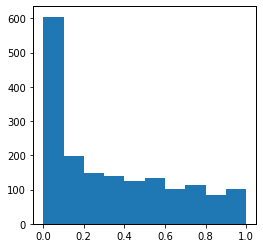

(1753, 2)


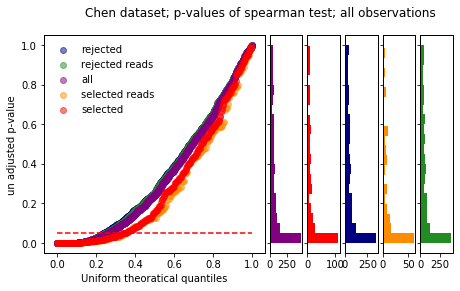

(1753, 2)
filter
1753
458
319
112
(0.9999703210753901, 5.210750401858605e-05)
reads
1753
458
179
62
(0.9970982683224787, 0.004828374234432423)


In [54]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, psi_bin = 0.1, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;', one_test = True)

2510
(2510, 202)
(2633, 202)
not pass
1422


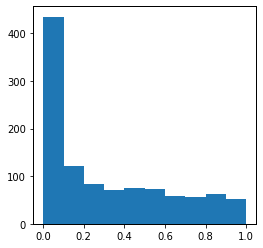

(1088, 2)


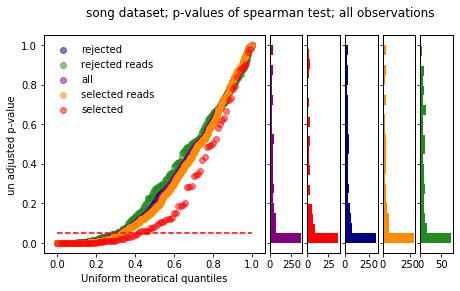

(1088, 2)
filter
1088
358
89
37
(0.9718713157721939, 0.04637383963167599)
reads
1088
358
848
285
(0.8430291936367402, 0.19770283767958363)


In [55]:
test_spearman_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                      song_pca_clust, clusters = 'AC', psi_min = 0.05, psi_bin = 0.1, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'song dataset;', one_test = False)

2510
(2510, 202)
(2633, 202)
not pass
625


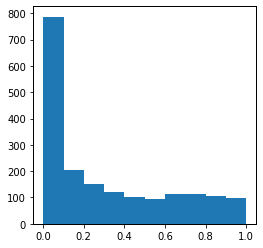

(1885, 2)


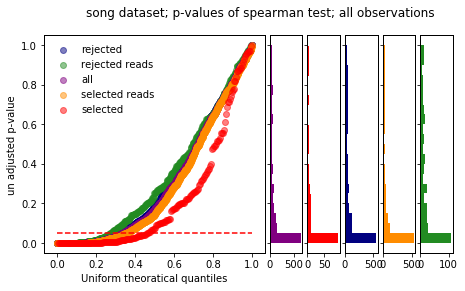

(1885, 2)
filter
1885
642
198
92
(0.9999516850728365, 8.990574547171687e-05)
reads
1885
642
1491
533
(0.9990560286022178, 0.0014204265155496915)


In [56]:
test_spearman_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                      song_pca_clust, clusters = 'AC', psi_min = 0.05, psi_bin = 0.1, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'song dataset;', one_test = True)

In [57]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, psi_bin = 0.25, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;', filter_obs=True)

1913
(1967, 488)
(2081, 488)


KeyboardInterrupt: 

In [ ]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, psi_bin = 0.25, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [58]:
def test_exon_bimodal_spearman(PSI_tab, exon, pca_clust, clusters = 'AC', one_test = False):
    
#     print(psi_lim)
    
    obs_cells = PSI_tab.loc[exon].dropna().index
    
    if one_test:
        
        
        psi = list(PSI_tab.loc[exon, obs_cells])
        pseudotime =  list(pca_clust.loc[obs_cells, 'pseudotime'])
        
        spearman_p = spearmanr(pseudotime, psi)[1]
    
            
    else:
        
        pvals = []
#         print('len')
#         print(len(pca_clust[clusters].unique()))
        forh i in range(len(pca_clust[clusters].unique()) - 1):
            
            c1 = i
            c2 = i+1
#             t = time.time()
            c1_ = pca_clust.loc[pca_clust[clusters] == c1].index
            c2_ = pca_clust.loc[pca_clust[clusters] == c2].index
            c1_cells = [x for x in obs_cells if x in c1_]
            c2_cells = [x for x in obs_cells if x in c2_]
#             print('time')
#             print(time.time()-t)
            
            cluster_cells = list(c1_cells) + list(c2_cells)
            psi = list(PSI_tab.loc[exon, cluster_cells])
            pseudotime =  list(pca_clust.loc[cluster_cells, 'pseudotime'])
            
            if (len(c1_cells) >= 10) and (len(c2_cells) >= 10):
                pvals.append(spearmanr(pseudotime, psi)[1])
#         print(len(pvals))
        if len(pvals) >= 2:
            spearman_p = combine_pvalues(pvals)[1]
        else:
            spearman_p = np.nan
        
    return spearman_p, np.mean(pseudotime), np.mean(psi)





def cluster_spearman_test(PSI_tab, pca_clust, clusters, correction = 'fdr_bh', 
                          correct_multitest = True, one_test = False):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg = test_exon_bimodal_spearman(PSI_tab, exon, pca_clust, clusters = 'AC', 
                                                     one_test = one_test)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            

        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame()
    cluster_df['array'] = cluster_array
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_spearman_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, pca_clust, clusters = 'AC',
                     psi_min = 0.2, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = '', one_test = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_spearman_test(aver_all[0].loc[joint_idx], pca_clust, clusters, 
                                                  one_test = one_test)
        change_tab_reads, chi_p_reads = cluster_spearman_test(aver_all_reads[0].loc[joint_idx], pca_clust, 
                                                              clusters, one_test = one_test)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_spearman_test(PSI_tab.loc[joint_idx], pca_clust, clusters, one_test = one_test)
        
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    joint_idx = change_tab.index
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of spearman test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of spearman test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
    else:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([0, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(change_tab.shape)
    
    N = len([x for x in aver[0].index if x in change_tab.index])
    k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    if filter_obs:
        M = len(chi_p_reads)
        n = np.sum([x <= 0.05 for x in chi_p_reads])

        N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
        k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
    else:
        M = len(chi_p)
        n = np.sum([x <= 0.05 for x in chi_p])

        N = len([x for x in aver_reads[0].index if x in change_tab.index])
        k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return 

not pass
27


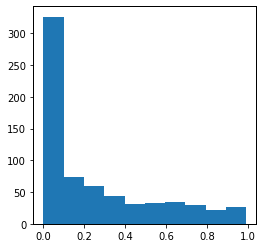

(680, 2)


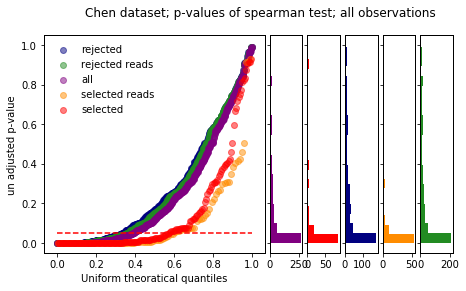

(680, 2)
filter
680
265
156
89
(0.9999999470688347, 1.437177714567753e-07)
reads
680
265
90
54
(0.9999957003501141, 1.2157242196638693e-05)


In [59]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

2510
(2510, 202)
(2633, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


not pass
549


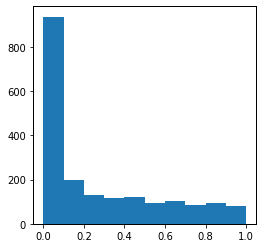

(1961, 2)


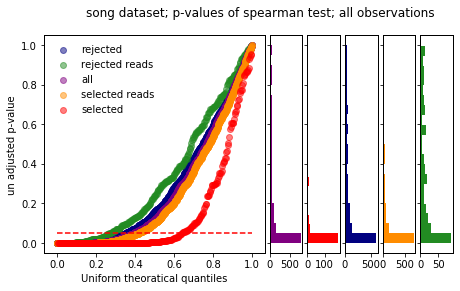

(1961, 2)
filter
1961
776
280
179
(0.9999999999988758, 4.960525596594107e-19)
reads
1961
776
1643
690
(0.9999998742501743, 2.5143731866569446e-07)


In [60]:
test_spearman_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                      song_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'song dataset;')

707
(733, 488)
(769, 488)
not pass
0


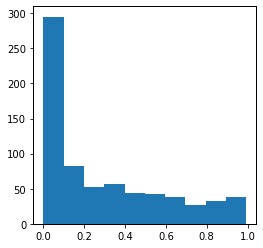

(707, 2)


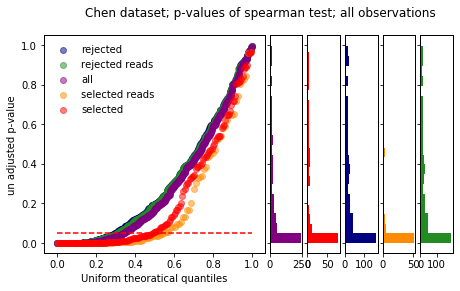

(707, 2)
filter
707
242
158
78
(0.999997555737162, 5.81362578886317e-06)
reads
707
242
92
51
(0.9999978597702266, 6.194658144550403e-06)


In [61]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;', one_test = True)

1913
(1967, 488)
(2081, 488)
not pass
0


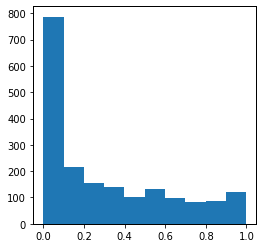

(1913, 2)


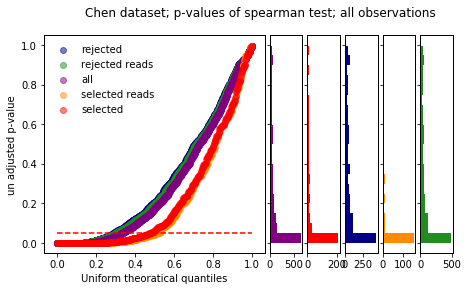

(1913, 2)
filter
1913
644
437
211
(1.0, 3.458797687779184e-13)
reads
1913
644
288
152
(1.0, 2.981965941142497e-13)


In [62]:
test_spearman_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;', one_test = True)

739
(739, 202)
(778, 202)
not pass
0


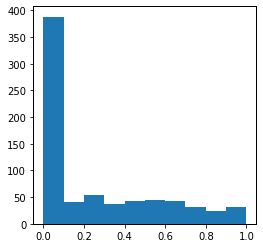

(739, 2)


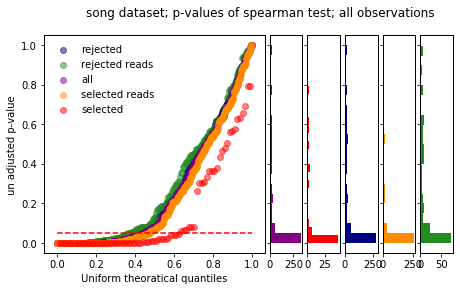

(739, 2)
filter
739
330
76
48
(0.9998029395421184, 0.0004856765166037487)
reads
739
330
542
257
(0.9953476811573742, 0.00752124693941638)


In [63]:
test_spearman_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                      song_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'song dataset;', one_test = True)

767
(767, 202)
(778, 202)
not pass
0


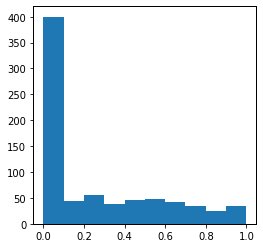

(767, 2)


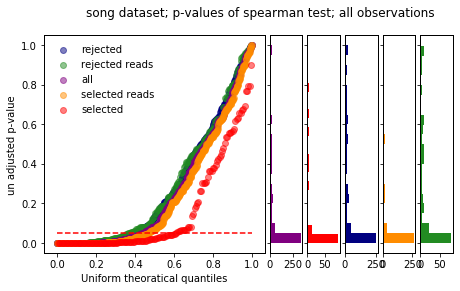

(767, 2)
filter
767
341
148
91
(0.9999988525842493, 2.8045967030769278e-06)
reads
767
341
551
261
(0.9963452805940597, 0.005883697205245498)


In [64]:
test_spearman_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                      song_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.25, 
                      mrna_min = 6, read_min =10, dset_name = 'song dataset;', one_test = True)

In [299]:
from scipy.stats import f_oneway


def run_anova(samples):
    if len(samples) == 2:
        return f_oneway(samples[0], samples[1])
    elif len(samples) == 3:
        return f_oneway(samples[0], samples[1], samples[2])
    elif len(samples) == 4:
        return f_oneway(samples[0], samples[1], samples[2], samples[3])
    elif len(samples) == 5:
        return f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4])
    elif len(samples) == 6:
        return f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4], samples[5])
    

def test_exon_bimodal_anova(PSI_tab, exon, pca_clust, clusters = 'AC', obs_min=0.5):
    
#     print(psi_lim)
    
    obs_cells = PSI_tab.loc[exon].dropna().index
    
    cluster_psi = []
    
    for i in pca_clust[clusters].unique():
#         t1 = time.time()
        clust_cells = pca_clust.loc[pca_clust[clusters] == i].index
        c_cells = [x for x in obs_cells if x in clust_cells]
#         print('time1')
#         print(time.time()-t1)
#         if len(c_cells) >= 10: #########################
        if len(c_cells)/len(clust_cells) >= obs_min:
            psi = list(PSI_tab.loc[exon, c_cells])
            cluster_psi.append(psi)
    if len(cluster_psi) >= 3:
        anova_p = run_anova(cluster_psi)[1]
    else:
        anova_p = np.nan
        
        
    return anova_p, len(cluster_psi), 10


def cluster_anova_test(PSI_tab, pca_clust, clusters, correction = 'fdr_bh', 
                          correct_multitest = True, obs_min = 0.5):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    completed = 0
    
    for exon in PSI_tab.index:
#         t = time.time()
        anv_p, pos, neg = test_exon_bimodal_anova(PSI_tab, exon, pca_clust, clusters = 'AC', obs_min=obs_min)
        if not np.isnan(anv_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(anv_p)
            exon_pass.append(exon)
    

        else:
            not_pass += 1
        completed += 1
#         print('time')
#         print(time.time()-t)
        if completed % 100 == 0:
            print (completed)
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method='fdr_bh')[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame()
    cluster_df['array'] = cluster_array
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_anova_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, pca_clust, clusters = 'AC',
                     psi_min = 0.2, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = '', correct_multitest = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_anova_test(aver_all[0].loc[joint_idx], pca_clust, clusters, obs_min=obs_min)
        change_tab_reads, chi_p_reads = cluster_anova_test(aver_all_reads[0].loc[joint_idx], pca_clust, clusters, obs_min=obs_min)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_anova_test(PSI_tab.loc[joint_idx], pca_clust, clusters, obs_min=obs_min)
        
    if correct_multitest:
        chi_p = multipletests(chi_p, method='fdr_bh')[1]
        change_tab['pvals'] = list(chi_p)
        print('corrected')
    else:
        
        change_tab['pvals'] = chi_p
        print('uncorrected')
    
    print(change_tab.shape)
    
    joint_idx = change_tab.index
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle(dset_name + ' p-values of anova test; selected observations')
    else:
        fig.suptitle(dset_name + ' p-values of anova test; all observations')

    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))
    ax_marg_x3.set_ylim((-0.05,1.05))
    ax_marg_x4.set_ylim((-0.05,1.05))
    ax_marg_x5.set_ylim((-0.05,1.05))
    if filter_obs:
        ax_marg_x6 = fig.add_subplot(gs[0:6,11])
        ax_marg_x6.set_ylim((-0.05,1.05))
        plt.setp(ax_marg_x6.get_yticklabels(), visible=False)
    
    
    if filter_obs:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in change_tab.index if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        ax_joint.scatter(probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab_reads.loc[[x for x in change_tab_reads.index if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in change_tab.index if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')
    
    
    else:
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                     probplot(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected')



        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='forestgreen', label='rejected reads')
        
        ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='purple', label='all')

        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='darkorange', label='selected reads')
        
        ax_joint.scatter(probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][0], 
                         probplot(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], dist='uniform')[0][1], 
                         alpha = 0.5, c='red', label='selected')

    
    ax_joint.plot([0, 1], [0.05, 0.05], 'r--')
    
    if filter_obs:
        ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        
        ax_marg_x4.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        ax_marg_x5.hist(change_tab_reads.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
        ax_marg_x6.hist(change_tab_reads.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        
        
    else:
        
        ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple', bins=20)
        ax_marg_x2.hist(change_tab.loc[[x for x in aver[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='red', bins=20)
        ax_marg_x3.hist(change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], 
                        orientation="horizontal", color='navy', bins=20)
        
        
        ax_marg_x4.hist(change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], 
                        orientation="horizontal", color='darkorange', bins=20)
        ax_marg_x5.hist(change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals'], 
                        orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
#     M = len(chi_p)
#     n = np.sum([x <= 0.05 for x in chi_p])
    
#     print(change_tab.shape)
    
#     N = len([x for x in aver[0].index if x in change_tab.index])
#     k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
#     print('filter')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
#     if filter_obs:
#         M = len(chi_p_reads)
#         n = np.sum([x <= 0.05 for x in chi_p_reads])

#         N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
#         k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
#     else:
#         M = len(chi_p)
#         n = np.sum([x <= 0.05 for x in chi_p])

#         N = len([x for x in aver_reads[0].index if x in change_tab.index])
#         k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

#     print('reads')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
    return list(chi_p), list(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals']), change_tab.loc[[x for x in aver_reads[0].index if x in joint_idx], 'pvals'], change_tab.loc[[x for x in joint_idx if x not in aver[0].index], 'pvals'], change_tab.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'pvals']

1913
(1967, 488)
(2081, 488)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
not pass
133


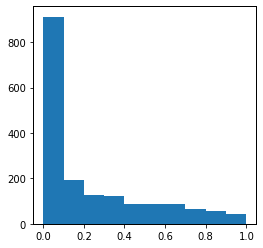

uncorrected
(1780, 2)


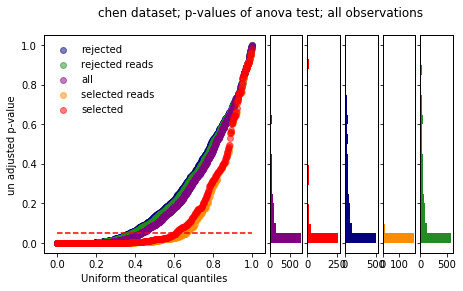

In [350]:
pvals, pvals_mrna, pvals_read, pvals_umrna, pvals_uread = test_anova_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'chen dataset;', correct_multitest = False)#correct_multitest = False

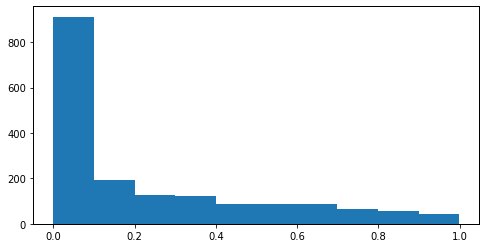

In [351]:
plt.hist(pvals)
plt.show()

In [352]:
recall_t = []
recall = []
recall_r = []
recall_u = []
recall_ur = []


specificity_t = []
specificity = []
specificity_r = []
specificity_u = []
specificity_ur = []

for x in np.arange(0.0001, 1.0001, 0.0001):
    total_p = np.sum(np.array(pvals) <= x)
    selected_p = np.sum(np.array(pvals_mrna) <= x)
    selected_u = np.sum(np.array(pvals_umrna) <= x)
    selected_r = np.sum(np.array(pvals_read) <= x)
    selected_ur = np.sum(np.array(pvals_uread) <= x)
    recall.append(selected_p/total_p)
    recall_u.append(selected_u/total_p)
    recall_r.append(selected_r/total_p)
    recall_ur.append(selected_ur/total_p)
    recall_t.append(1)
    
    
    total_neg = len(pvals) - total_p
    
    false_pos = len(pvals_mrna) - selected_p
    true_neg = total_neg - false_pos
    specificity_mrna = true_neg/total_neg
    
    
    false_pos = len(pvals_read) - selected_r
    true_neg = total_neg - false_pos
    specificity_read = true_neg/total_neg
    
    
    false_pos = len(pvals_umrna) - selected_u
    true_neg = total_neg - false_pos
    specificity_umrna = true_neg/total_neg
    
    
    false_pos = len(pvals_uread) - selected_ur
    true_neg = total_neg - false_pos
    specificity_uread = true_neg/total_neg
    
    specificity.append(specificity_mrna)
    specificity_r.append(specificity_read)
    specificity_ur.append(specificity_uread)
    specificity_u.append(specificity_umrna)

load_data.py:31: RuntimeWarning: invalid value encountered in long_scalars
  from sklearn.cluster import AgglomerativeClustering
load_data.py:36: RuntimeWarning: invalid value encountered in long_scalars
  # PSI tables
load_data.py:41: RuntimeWarning: invalid value encountered in long_scalars
  sep='\t',  index_col=0)
load_data.py:46: RuntimeWarning: invalid value encountered in long_scalars
  # SJ read tables


In [353]:
recall_t = []
recall = []
recall_r = []
recall_u = []
recall_ur = []


specificity_t = []
specificity = []
specificity_r = []
specificity_u = []
specificity_ur = []

for x in np.arange(0.0001, 1.0001, 0.0001):
    total_p = np.sum(np.array(pvals) <= x)
    selected_p = np.sum(np.array(pvals_mrna) <= x)
    selected_u = np.sum(np.array(pvals_umrna) <= x)
    selected_r = np.sum(np.array(pvals_read) <= x)
    selected_ur = np.sum(np.array(pvals_uread) <= x)
    recall.append(selected_p/total_p)
    recall_u.append(selected_u/total_p)
    recall_r.append(selected_r/total_p)
    recall_ur.append(selected_ur/total_p)
    recall_t.append(1)
    
    
    total_neg = len(pvals) - total_p
    
    false_pos = len(pvals_mrna) - selected_p
    true_neg = total_neg - false_pos
    specificity_mrna = true_neg/total_neg
    
    
    false_pos = len(pvals_read) - selected_r
    true_neg = total_neg - false_pos
    specificity_read = true_neg/total_neg
    
    
    false_pos = len(pvals_umrna) - selected_u
    true_neg = total_neg - false_pos
    specificity_umrna = true_neg/total_neg
    
    
    false_pos = len(pvals_uread) - selected_ur
    true_neg = total_neg - false_pos
    specificity_uread = true_neg/total_neg
    
    specificity.append(specificity_mrna)
    specificity_r.append(specificity_read)
    specificity_ur.append(specificity_uread)
    specificity_u.append(specificity_umrna)

load_data.py:31: RuntimeWarning: invalid value encountered in long_scalars
  from sklearn.cluster import AgglomerativeClustering
load_data.py:36: RuntimeWarning: invalid value encountered in long_scalars
  # PSI tables
load_data.py:41: RuntimeWarning: invalid value encountered in long_scalars
  sep='\t',  index_col=0)
load_data.py:46: RuntimeWarning: invalid value encountered in long_scalars
  # SJ read tables


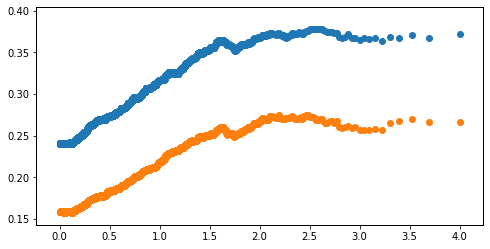

In [354]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_r)
# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),curva_u)
# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),curva_ur)
plt.show()

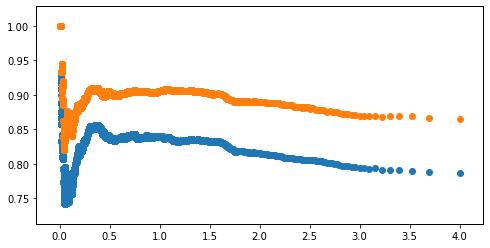

In [355]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),specificity)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),specificity_r)
# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),curva_u)
# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),curva_ur)
plt.show()

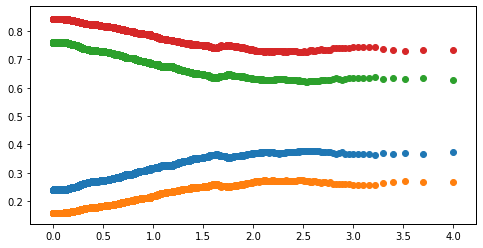

In [356]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_r)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_u)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_ur)
plt.show()

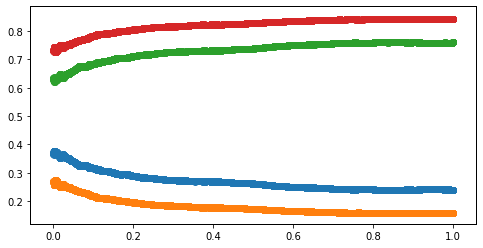

In [357]:
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),recall)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),recall_r)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),recall_u)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),recall_ur)
plt.show()

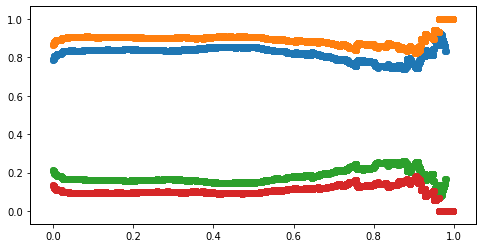

In [358]:
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),specificity)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),specificity_r)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),specificity_u)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),specificity_ur)
plt.show()

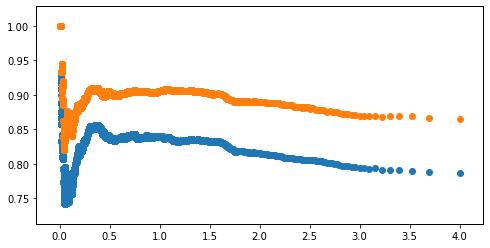

In [359]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),specificity)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),specificity_r)
# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),specificity_u)
# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),specificity_ur)
plt.show()

In [360]:
precision_t = []
precision = []
precision_r = []
precision_u = []
precision_ur = []
for x in np.arange(0.0001, 1.0001, 0.0001):
    total_p = np.sum(np.array(pvals) <= x)
    selected_p = np.sum(np.array(pvals_mrna) <= x)
    selected_u = np.sum(np.array(pvals_umrna) <= x)
    selected_r = np.sum(np.array(pvals_read) <= x)
    selected_ur = np.sum(np.array(pvals_uread) <= x)
    precision.append(selected_p/len(pvals_mrna))
    precision_u.append(selected_u/len(pvals_umrna))
    precision_r.append(selected_r/len(pvals_read))
    precision_ur.append(selected_ur/len(pvals_uread))
    precision_t.append(total_p/len(pvals))

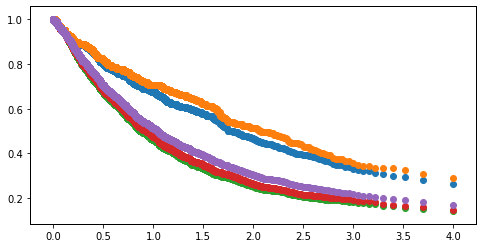

In [361]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),precision)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),precision_r)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),precision_u)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),precision_ur)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),precision_t)
plt.show()

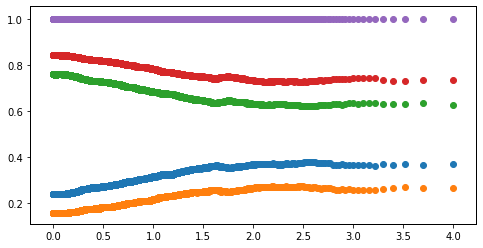

In [362]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_r)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_u)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_ur)
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),recall_t)
plt.show()

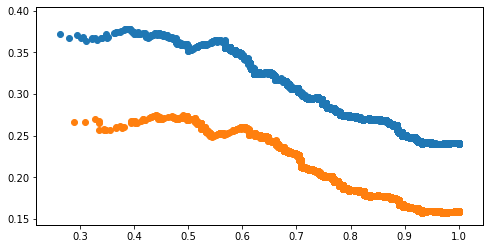

In [363]:
plt.scatter(precision, recall)
plt.scatter(precision_r, recall_r)
plt.show()

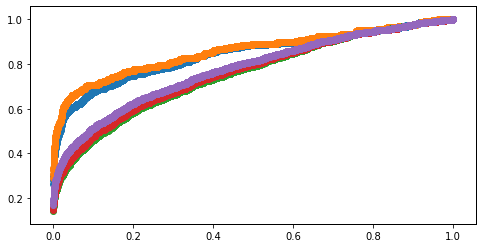

In [364]:
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),precision)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),precision_r)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),precision_u)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),precision_ur)
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),precision_t)

plt.show()

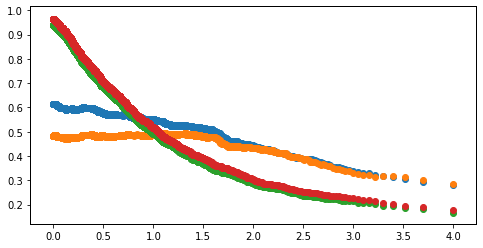

In [316]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (5*np.array(recall)*np.array(precision))/((4*np.array(recall))+np.array(precision)))
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (5*np.array(recall_r)*np.array(precision_r))/((4*np.array(recall_r))+np.array(precision_r)))



plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (5*np.array(recall_u)*np.array(precision_u))/((4*np.array(recall_u))+np.array(precision_u)))

plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (5*np.array(recall_ur)*np.array(precision_ur))/((4*np.array(recall_ur))+np.array(precision_ur)))


# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_t)*np.array(precision_t))/(np.array(recall_t)+np.array(precision_t)))


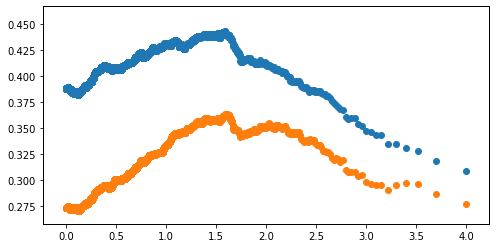

In [317]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall)*np.array(precision))/(np.array(recall)+np.array(precision)))
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall_r)*np.array(precision_r))/(np.array(recall_r)+np.array(precision_r)))



# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_u)*np.array(precision_u))/(np.array(recall_u)+np.array(precision_u)))

# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_ur)*np.array(precision_ur))/(np.array(recall_ur)+np.array(precision_ur)))


# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_t)*np.array(precision_t))/(np.array(recall_t)+np.array(precision_t)))


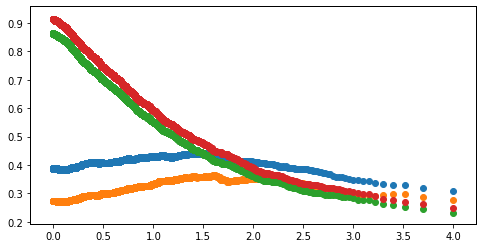

In [318]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall)*np.array(precision))/(np.array(recall)+np.array(precision)))
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall_r)*np.array(precision_r))/(np.array(recall_r)+np.array(precision_r)))



plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall_u)*np.array(precision_u))/(np.array(recall_u)+np.array(precision_u)))

plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall_ur)*np.array(precision_ur))/(np.array(recall_ur)+np.array(precision_ur)))


# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_t)*np.array(precision_t))/(np.array(recall_t)+np.array(precision_t)))


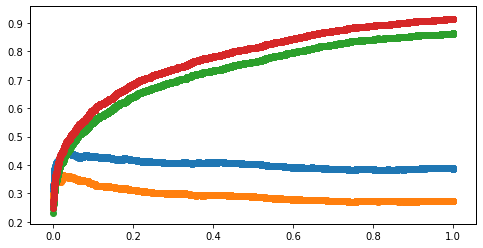

In [319]:
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),
            (2*np.array(recall)*np.array(precision))/(np.array(recall)+np.array(precision)))
plt.scatter(np.arange(0.0001, 1.0001, 0.0001),
            (2*np.array(recall_r)*np.array(precision_r))/(np.array(recall_r)+np.array(precision_r)))

plt.scatter(np.arange(0.0001, 1.0001, 0.0001),
            (2*np.array(recall_u)*np.array(precision_u))/(np.array(recall_u)+np.array(precision_u)))

plt.scatter(np.arange(0.0001, 1.0001, 0.0001),
            (2*np.array(recall_ur)*np.array(precision_ur))/(np.array(recall_ur)+np.array(precision_ur)))

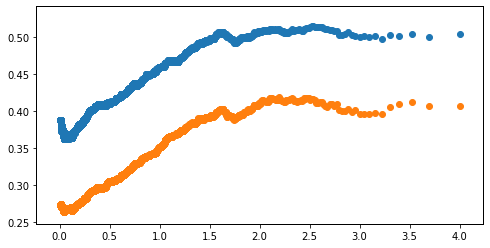

In [320]:
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall)*np.array(specificity))/(np.array(recall)+np.array(specificity)))
plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
            (2*np.array(recall_r)*np.array(specificity_r))/(np.array(recall_r)+np.array(specificity_r)))



# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_u)*np.array(specificity_u))/(np.array(recall_u)+np.array(specificity_u)), c='purple')

# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_ur)*np.array(specificity_ur))/(np.array(recall_ur)+np.array(specificity_ur)))


# plt.scatter(-np.log10(np.arange(0.0001, 1.0001, 0.0001)),
#             (2*np.array(recall_t)*np.array(specificity_t))/(np.array(recall_t)+np.array(specificity_t)))


In [348]:
def get_recall(pvals, pvals_selected, x):
    total_p = np.sum(np.array(pvals) <= x)
    selected_p = np.sum(np.array(pvals_selected) <= x)
    recall = selected_p/total_p
    return recall

def get_precision(pvals_selected, x):
    selected_p = np.sum(np.array(pvals_selected) <= x)
    total_selected = len(pvals_selected)
    precision = selected_p/total_selected
    return precision

def get_specificity(pvals, pvals_selected, x):
    total_p = np.sum(np.array(pvals) <= x)
    selected_p = np.sum(np.array(pvals_selected) <= x)
    total_neg = len(pvals) - total_p
    false_pos = len(pvals_selected) - selected_p
    true_neg = total_neg - false_pos
    specificity = true_neg/total_neg
    return specificity
    

def summary_plots(pvals, pvals_mrna, pvals_read, pvals_umrna='', pvals_uread='', p_lim=1, p_steps = 0.0001, plot_inter=False):
    
    
    recall_mrna = []
    recall_read = []
    precision_mrna = []
    precision_read = []
    specificity_mrna = []
    specificity_read = []
    
    if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
    
        recall_umrna = []
        recall_uread = []
        precision_umrna = []
        precision_uread = []
        specificity_umrna = []
        specificity_uread = []

    p_limits = np.arange(p_steps, p_lim + p_steps, p_steps)
    
    for x in p_limits:
        recall_mrna.append(get_recall(pvals, pvals_mrna, x))
        recall_read.append(get_recall(pvals, pvals_read, x))
        
        precision_mrna.append(get_precision(pvals_mrna, x))
        precision_read.append(get_precision(pvals_read, x))
        
        specificity_mrna.append(get_specificity(pvals, pvals_mrna, x))
        specificity_read.append(get_specificity(pvals, pvals_read, x))
        
        if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
            
            recall_umrna.append(get_recall(pvals, pvals_umrna, x))
            recall_uread.append(get_recall(pvals, pvals_uread, x))

            precision_umrna.append(get_precision(pvals_umrna, x))
            precision_uread.append(get_precision(pvals_uread, x))

            specificity_umrna.append(get_specificity(pvals, pvals_umrna, x))
            specificity_uread.append(get_specificity(pvals, pvals_uread, x))
            
            
    recall_mrna = np.array(recall_mrna)
    recall_read = np.array(recall_read)     
            
    f1_score_mrna = (2*recall_mrna*precision_mrna)/(recall_mrna+precision_mrna)
    f1_score_read = (2*recall_read*precision_read)/(recall_read+precision_read)
    
    f_score_mrna = (2*recall_mrna*specificity_mrna)/(recall_mrna+specificity_mrna)
    f_score_read = (2*recall_read*specificity_read)/(recall_read+specificity_read)
    
    if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
        recall_umrna = np.array(recall_umrna)
        recall_uread = np.array(recall_uread)
        
        f1_score_umrna = (2*recall_umrna*precision_umrna)/(recall_umrna+precision_umrna)
        f1_score_uread = (2*recall_uread*precision_uread)/(recall_uread+precision_uread)

        f_score_umrna = (2*recall_umrna*specificity_umrna)/(recall_umrna+specificity_umrna)
        f_score_uread = (2*recall_uread*specificity_uread)/(recall_uread+specificity_uread)
        
    if plot_inter:
        
        plt.figure()
        plt.scatter(-np.log10(p_limits), recall_mrna, alpha=0.5, c='navy', label='mrna filter')
        plt.scatter(-np.log10(p_limits), recall_read, alpha=0.5, c='darkred', label='read filter')
        if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
            plt.scatter(-np.log10(p_limits), recall_umrna, alpha=0.5, c='purple', label='mrna rejected')
            plt.scatter(-np.log10(p_limits), recall_uread, alpha=0.5, c='forestgreen', label='read rejected')

        plt.title('Sensitivity curves, Chen')
        plt.xlabel('-log10 p-value')
        plt.ylabel('Sensitivity (classifier precision)')
        plt.legend()
        plt.show()

        plt.figure()
        plt.scatter(-np.log10(p_limits), precision_mrna, alpha=0.5, c='navy', label='mrna filter')
        plt.scatter(-np.log10(p_limits), precision_read, alpha=0.5, c='darkred', label='read filter')
        if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
            plt.scatter(-np.log10(p_limits), precision_umrna, alpha=0.5, c='purple', label='mrna rejected')
            plt.scatter(-np.log10(p_limits), precision_uread, alpha=0.5, c='forestgreen', label='read rejected')

        plt.title('Precision curves, Chen')
        plt.xlabel('-log10 p-value')
        plt.ylabel('Precision (classifier sensitivity)')
        plt.legend()
        plt.show()

        plt.figure()
        plt.scatter(-np.log10(p_limits), specificity_mrna, alpha=0.5, c='navy', label='mrna filter')
        plt.scatter(-np.log10(p_limits), specificity_read, alpha=0.5, c='darkred', label='read filter')
        if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
            plt.scatter(-np.log10(p_limits), specificity_umrna, alpha=0.5, c='purple', label='mrna rejected')
            plt.scatter(-np.log10(p_limits), specificity_uread, alpha=0.5, c='forestgreen', label='read rejected')

        plt.title('specificity, Chen')
        plt.xlabel('-log10 p-value')
        plt.ylabel('specificity')
        plt.legend()
        plt.show()


    plt.figure()
    plt.scatter(-np.log10(p_limits), f1_score_mrna, alpha=0.5, c='navy', label='mrna filter')
    plt.scatter(-np.log10(p_limits), f1_score_read, alpha=0.5, c='darkred', label='read filter')
    if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
        plt.scatter(-np.log10(p_limits), f1_score_umrna, alpha=0.5, c='purple', label='mrna rejected')
        plt.scatter(-np.log10(p_limits), f1_score_uread, alpha=0.5, c='forestgreen', label='read rejected')

    plt.title('f1_score curves, Chen')
    plt.xlabel('-log10 p-value')
    plt.ylabel('f1_score')
    plt.legend()
    plt.show()


    plt.figure()
    plt.scatter(-np.log10(p_limits), f_score_mrna, alpha=0.5, c='navy', label='mrna filter')
    plt.scatter(-np.log10(p_limits), f_score_read, alpha=0.5, c='darkred', label='read filter')
    if (len(pvals_umrna) > 0) and (len(pvals_uread) > 0):
        plt.scatter(-np.log10(p_limits), f_score_umrna, alpha=0.5, c='purple', label='mrna rejected')
        plt.scatter(-np.log10(p_limits), f_score_uread, alpha=0.5, c='forestgreen', label='read rejected')

    plt.title('harmonic mean sensitivity/specificity, Song')
    plt.xlabel('-log10 p-value')
    plt.ylabel('f_score')
    plt.legend()
    plt.show()



load_data.py:19: RuntimeWarning: invalid value encountered in long_scalars
  import single_cell_plots as scp


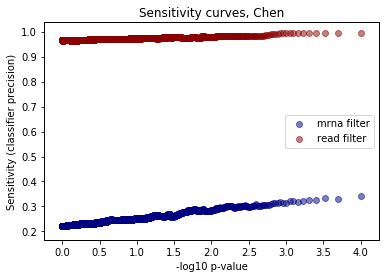

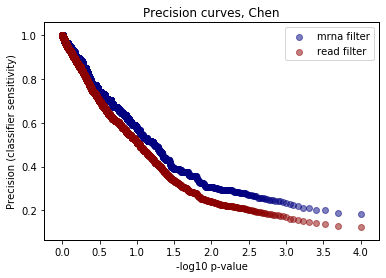

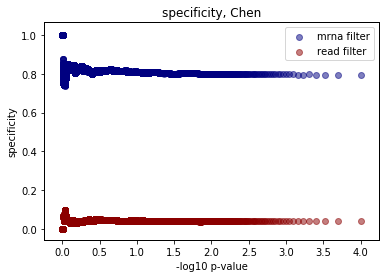

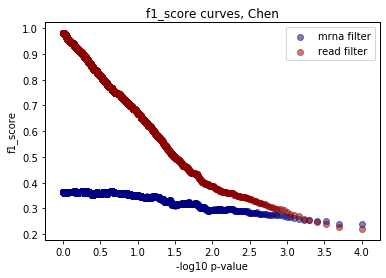

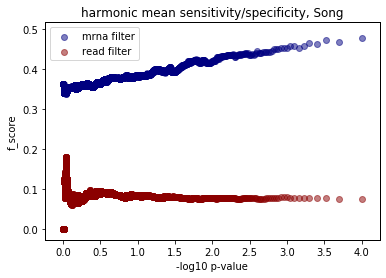

In [349]:
figsize(6, 4)
summary_plots(pvals, pvals_mrna, pvals_read, p_lim=1, p_steps = 0.0001, plot_inter=True)

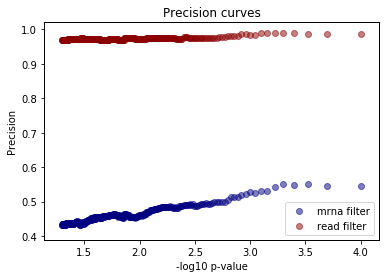

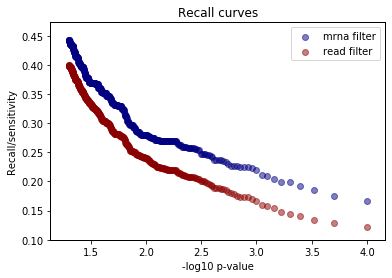

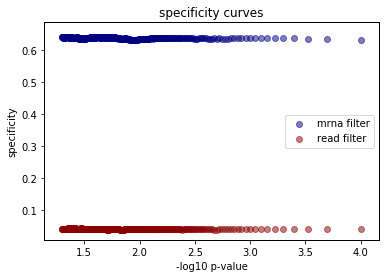

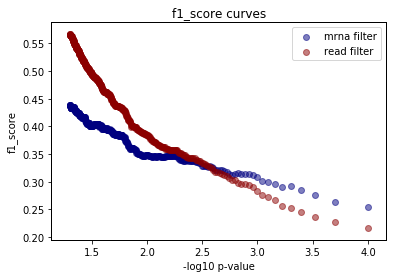

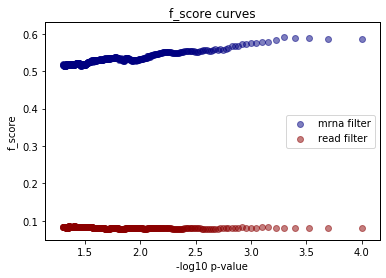

In [332]:
summary_plots(pvals, pvals_mrna, pvals_read, p_lim=0.05, p_steps = 0.0001,plot_inter=True)

In [208]:
# This
# Boxplots for bimodality curves
# Shalek

In [261]:
pvals, pvals_mrna, pvals_read, pvals_umrna, pvals_uread = test_anova_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                      trapnell_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.25, 
                      mrna_min = 5, read_min =10, dset_name = 'trapnell dataset;', correct_multitest = True)#correct_multitest = False

TypeError: test_anova_filters() got an unexpected keyword argument 'correct_multitest'

load_data.py:19: RuntimeWarning: invalid value encountered in long_scalars
  import single_cell_plots as scp


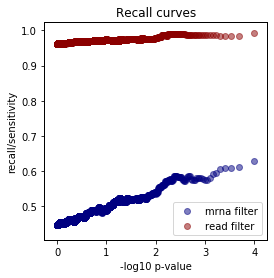

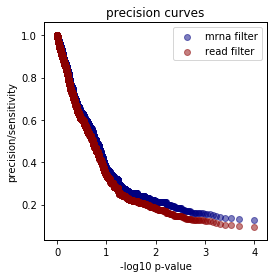

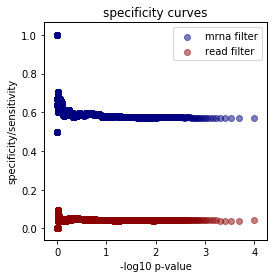

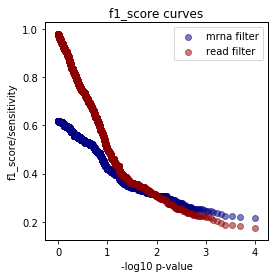

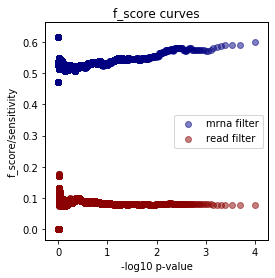

In [91]:
summary_plots(pvals, pvals_mrna, pvals_read, p_lim=1, p_steps = 0.0001, plot_inter=True)

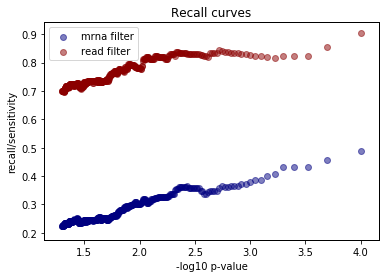

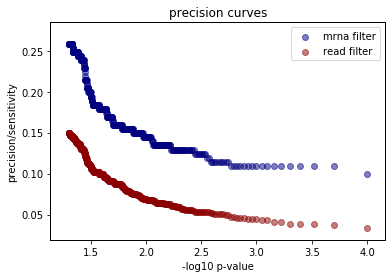

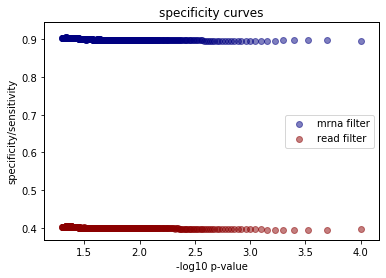

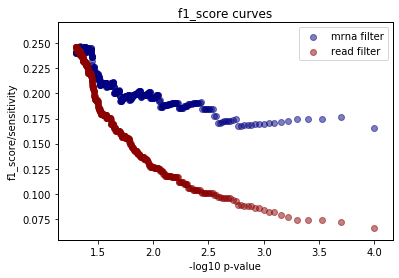

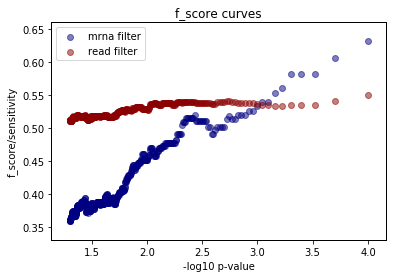

In [213]:
summary_plots(pvals, pvals_mrna, pvals_read, p_lim=0.05, p_steps = 0.0001,plot_inter=True)

In [288]:
from scipy.stats import f_oneway


def run_anova(samples):
    if len(samples) == 2:
        return f_oneway(samples[0], samples[1])
    elif len(samples) == 3:
        return f_oneway(samples[0], samples[1], samples[2])
    elif len(samples) == 4:
        return f_oneway(samples[0], samples[1], samples[2], samples[3])
    elif len(samples) == 5:
        return f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4])
    elif len(samples) == 6:
        return f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4], samples[5])
    

def test_exon_bimodal_anova(PSI_tab, exon, pca_clust, clusters = 'AC', obs_min=0.5):
    
#     print(psi_lim)
    
    obs_cells = PSI_tab.loc[exon].dropna().index
    
    cluster_psi = []
    
    for i in pca_clust[clusters].unique():
#         t1 = time.time()
        clust_cells = pca_clust.loc[pca_clust[clusters] == i].index
        c_cells = [x for x in obs_cells if x in clust_cells]
#         print('time1')
#         print(time.time()-t1)
#         if len(c_cells) >= 10: #########################
        if len(c_cells)/len(clust_cells) >= obs_min:
            psi = list(PSI_tab.loc[exon, c_cells])
            cluster_psi.append(psi)
    if len(cluster_psi) >= 3:
        anova_p = run_anova(cluster_psi)[1]
    else:
        anova_p = np.nan
        
        
    return anova_p, len(cluster_psi), 10


def cluster_anova_test(PSI_tab, pca_clust, clusters, correction = 'fdr_bh', 
                          correct_multitest = True, obs_min = 0.5):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    completed = 0
    
    for exon in PSI_tab.index:
#         t = time.time()
        anv_p, pos, neg = test_exon_bimodal_anova(PSI_tab, exon, pca_clust, clusters = 'AC', obs_min=obs_min)
        if not np.isnan(anv_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(anv_p)
            exon_pass.append(exon)
    

        else:
            not_pass += 1
        completed += 1
#         print('time')
#         print(time.time()-t)
        if completed % 100 == 0:
            print (completed)
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame()
    cluster_df['array'] = cluster_array
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_anova_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, pca_clust, clusters = 'AC',
                     psi_min = 0.2, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)
    
    
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, 0, 0)
    
    

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
#     joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
    
    if filter_obs:
        change_tab, chi_p = cluster_anova_test(aver_all[0].loc[joint_idx], pca_clust, clusters, obs_min=obs_min)
        change_tab_reads, chi_p_reads = cluster_anova_test(aver_all_reads[0].loc[joint_idx], pca_clust, 
                                                           clusters, obs_min=obs_min)
        change_tab_reads['pvals'] = chi_p_reads
    else:
        change_tab, chi_p = cluster_anova_test(PSI_tab.loc[joint_idx], pca_clust, clusters, obs_min=obs_min)
        
    change_tab['pvals'] = chi_p
    joint_idx = change_tab.index
    
    pvals_mrna = []
    pvals_reads = []
    
    for i in np.arange(0.1, mrna_min + 0.1, 0.1):

        aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
                  read_counts, i, 0, obs_min)

        aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
                  read_counts, 0, i, obs_min)
        
        
        pvals_mrna.append(list(change_tab.loc[[x for x in joint_idx if x in aver[0].index], 'pvals']))
        pvals_reads.append(list(change_tab.loc[[x for x in joint_idx if x in aver_reads[0].index], 'pvals']))
        
        print(i)
        
    return list(chi_p), pvals_mrna, pvals_reads
        

2633
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
not pass
1364


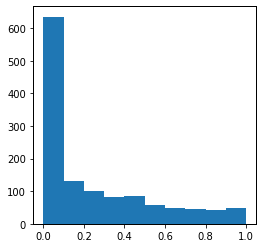

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.700000000000001
9.8
9.9
10.0
10.1
10.200000000000001
10.3
10.4
10.5
10.6
10.700000000000001
10.8
10.9
11.0
11.1
11.200000000000001
11.3
11.4
11.5
11.6
11.700000000000001
11.8
11.9
12.0
12.1
12.200000000000001
12.3
12.4
12.5
12.6
12.700000000000001
12.8
12.9
13.0
13.1
13.200000000000001
13.3
13.4
1

70.0
70.1
70.2
70.3
70.39999999999999
70.5
70.6
70.7
70.8
70.89999999999999
71.0
71.1
71.2
71.3
71.39999999999999
71.5
71.6
71.7
71.8
71.89999999999999
72.0
72.1
72.2
72.3
72.39999999999999
72.5
72.6
72.7
72.8
72.89999999999999
73.0
73.1
73.2
73.3
73.39999999999999
73.5
73.6
73.7
73.8
73.89999999999999
74.0
74.1
74.2
74.3
74.39999999999999
74.5
74.6
74.7
74.8
74.89999999999999
75.0
75.1
75.2
75.3
75.39999999999999
75.5
75.6
75.7
75.8
75.89999999999999
76.0
76.1
76.2
76.3
76.39999999999999
76.5
76.6
76.7
76.8
76.9
77.0
77.1
77.2
77.3
77.4
77.5
77.6
77.7
77.8
77.9
78.0
78.1
78.2
78.3
78.4
78.5
78.6
78.7
78.8
78.9
79.0
79.1
79.2
79.3
79.4
79.5
79.6
79.7
79.8
79.9
80.0
80.1
80.2
80.3
80.4
80.5
80.6
80.7
80.8
80.9
81.0
81.1
81.2
81.3
81.4
81.5
81.6
81.7
81.8
81.9
82.0
82.1
82.2
82.3
82.4
82.5
82.6
82.7
82.8
82.9
83.0
83.1
83.2
83.3
83.4
83.5
83.6
83.7
83.8
83.9
84.0
84.1
84.2
84.3
84.4
84.5
84.6
84.7
84.8
84.9
85.0
85.1
85.2
85.3
85.4
85.5
85.6
85.7
85.8
85.9
86.0
86.1
86.2
86.3
86.4
86.5
8

In [289]:
pvals, pvals_mrna, pvals_read = test_anova_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, 
                                                   song_coverage_tab, song_pca_clust, clusters = 'AC', psi_min = 0.05, 
                                                   obs_min = 0.25, mrna_min = 100, read_min =6, dset_name = 'song dataset;')

In [290]:
precision_mrna = []
precision_read = []
recall_mrna = []
recall_read = []
fpr_mrna = []
fpr_read = []

total_significant = np.sum(np.array(pvals) <= 0.05)
total_p = len(pvals)

ran = np.arange(0.1, 100 + 0.1, 0.1)

for i in range(len(np.arange(0.1, 100 + 0.1, 0.1))):
    pvals_mrna_i = len(pvals_mrna[i])
    significant_mrna_i = np.sum(np.array(pvals_mrna[i]) <= 0.05)
    precision_mrna_i = significant_mrna_i/pvals_mrna_i
    recall_mrna_i = significant_mrna_i/total_significant
    
    precision_mrna.append(precision_mrna_i)
    recall_mrna.append(recall_mrna_i)
    fpr_mrna_i = (pvals_mrna_i - significant_mrna_i)/(total_p - total_significant)
    fpr_mrna.append(fpr_mrna_i)
    
    pvals_read_i = len(pvals_read[i])
    significant_read_i = np.sum(np.array(pvals_read[i]) <= 0.05)
    precision_read_i = significant_read_i/pvals_read_i
    recall_read_i = significant_read_i/total_significant
    
    precision_read.append(precision_read_i)
    recall_read.append(recall_read_i)
    fpr_read_i = (pvals_read_i - significant_read_i)/(total_p - total_significant)
    fpr_read.append(fpr_read_i)

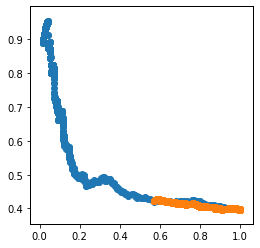

In [291]:
plt.scatter(recall_mrna, precision_mrna)
plt.scatter(recall_read, precision_read)
plt.show()

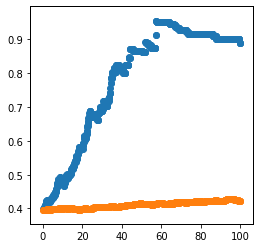

In [292]:
plt.scatter(ran, precision_mrna)
plt.scatter(ran, precision_read)
plt.show()

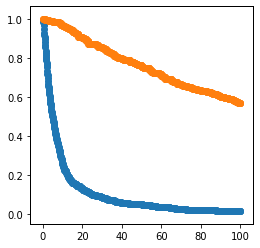

In [295]:
plt.scatter(ran, recall_mrna)
plt.scatter(ran, recall_read)
plt.show()

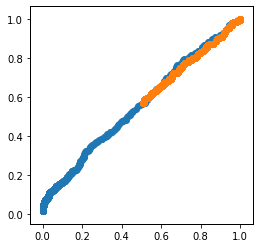

In [293]:
plt.scatter(fpr_mrna, recall_mrna)
plt.scatter(fpr_read, recall_read)
plt.show()

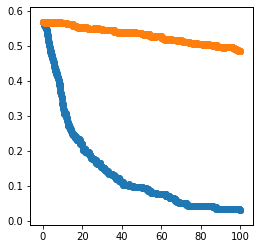

In [294]:
plt.scatter(ran,
            (2*np.array(recall_mrna)*np.array(precision_mrna))/(np.array(recall_mrna)+np.array(precision_mrna)))
plt.scatter(ran,
            (2*np.array(recall_read)*np.array(precision_read))/(np.array(recall_read)+np.array(precision_read)))


813
100
200
300
400
500
600
700
800
not pass
65


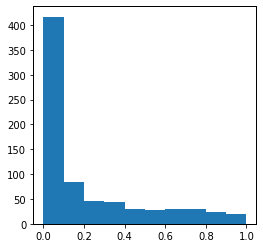

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.700000000000001
9.8
9.9
10.0


([0.09830509890223323,
  0.3986159453488564,
  0.9186377704400512,
  2.227545810060716e-09,
  0.18768174058761683,
  5.134317188924995e-10,
  4.1578512265406733e-07,
  2.859687743452806e-06,
  2.4111473093631692e-08,
  1.6818844607243114e-08,
  0.03160573183037009,
  1.0353199351731698e-06,
  0.0055899925509324995,
  0.9444192458910313,
  0.008326894810017207,
  0.08979855900177014,
  0.09116338372191657,
  0.7106906861896538,
  0.6363332755677094,
  0.6452275896163944,
  0.09988979370699211,
  0.17823832421095367,
  0.46208328350737937,
  0.03510610651757659,
  3.698941257207451e-05,
  0.1976172189105554,
  0.061387324675710765,
  0.03967215640149231,
  0.001976753361961296,
  0.07198114774288994,
  0.36997009156545374,
  7.646656703354664e-21,
  3.329350116858718e-27,
  0.7569777489593525,
  4.6349816872943175e-06,
  0.10288870386685317,
  0.42546673555754067,
  3.1904218292124608e-22,
  0.05388234680855383,
  0.3259334082623062,
  0.05755380347403436,
  0.19999402450890166,
  0.2847

In [247]:
test_anova_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'cell_type', psi_min = 0.2, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [ ]:
test_anova_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, 
                      lescroart_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'lescroart dataset;')

In [ ]:
test_anova_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;', filter_obs=True)

In [ ]:
test_anova_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.5, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;', filter_obs=True)

In [ ]:
test_anova_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                      song_pca_clust, clusters = 'AC', psi_min = 0.05, obs_min = 0.25, 
                      mrna_min = 10, read_min =10, dset_name = 'song dataset;')

In [ ]:
f_oneway(chen_PSI.loc['Cadm1_2', chen_pca_clust.AC==0].dropna(), 
         chen_PSI.loc['Cadm1_2', chen_pca_clust.AC==1].dropna(),
         chen_PSI.loc['Cadm1_2', chen_pca_clust.AC==2].dropna(),
         chen_PSI.loc['Cadm1_2', chen_pca_clust.AC==3].dropna(),
         chen_PSI.loc['Cadm1_2', chen_pca_clust.AC==4].dropna())

In [ ]:

chen_observed = chen_PSI.loc[chen_PSI.isna().mean(axis=1) <= (1-0.25)].index
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI.loc[chen_observed], chen_mrna_counts, 0.2)
    
chen_aver = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'],
              chen_read_counts, 10, 0, 0.1)

In [ ]:
f_oneway(chen_aver[0].loc['Cadm1_2', chen_pca_clust.AC==0].dropna(), 
         chen_aver[0].loc['Cadm1_2', chen_pca_clust.AC==1].dropna(),
         chen_aver[0].loc['Cadm1_2', chen_pca_clust.AC==2].dropna(),
         chen_aver[0].loc['Cadm1_2', chen_pca_clust.AC==3].dropna(),
         chen_aver[0].loc['Cadm1_2', chen_pca_clust.AC==4].dropna())

In [ ]:
from scipy.stats import f_oneway


def run_anova(samples):
    if len(samples) == 2:
        return f_oneway(samples[0], samples[1])
    elif len(samples) == 3:
        return f_oneway(samples[0], samples[1], samples[2])
    elif len(samples) == 4:
        return f_oneway(samples[0], samples[1], samples[2], samples[3])
    elif len(samples) == 5:
        return f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4])
    elif len(samples) == 6:
        return f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4], samples[5])
    

def test_exon_bimodal_anova(PSI_tab, exon, pca_clust, clusters = 'AC'):
    
#     print(psi_lim)
    
    obs_cells = PSI_tab.loc[exon].dropna().index
    
    cluster_psi = []
    
    for i in pca_clust[clusters].unique():
#         t1 = time.time()
        clust_cells = pca_clust.loc[pca_clust[clusters] == i].index
        c_cells = [x for x in obs_cells if x in clust_cells]
#         print('time1')
#         print(time.time()-t1)
        if len(c_cells) >= 10:
            psi = list(PSI_tab.loc[exon, c_cells])
            cluster_psi.append(psi)
    if len(cluster_psi) >= 3:
        anova_p = run_anova(cluster_psi)[1]
    else:
        anova_p = np.nan
        
        
    return anova_p, len(cluster_psi), 10


def cluster_anova_test(PSI_tab, pca_clust, clusters, correction = 'fdr_bh', 
                          correct_multitest = True):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    completed = 0
    
    for exon in PSI_tab.index:

        anv_p, pos, neg = test_exon_bimodal_anova(PSI_tab, exon, pca_clust, clusters = 'AC')
        if not np.isnan(anv_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(anv_p)
            exon_pass.append(exon)
    
        else:
            not_pass += 1
        completed += 1
        if completed % 100 == 0:
            print (completed)
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()

    cluster_df = pd.DataFrame()
    cluster_df['array'] = cluster_array
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_anova_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, pca_clust, clusters = 'AC',
                     psi_min = 0.2, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False, 
                    dset_name = ''):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
#     aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
#               read_counts, 0, read_min, obs_min)
    
    
    print(aver[0].shape)
#     print(aver_reads[0].shape)
    
    change_tab, chi_p = cluster_anova_test(aver[0], pca_clust, clusters)
    change_tab_reads, chi_p_reads = cluster_anova_test(PSI_tab.loc[aver[0].index], pca_clust, clusters)
    change_tab_reads['pvals'] = chi_p_reads
        
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    
    figsize(8, 4)
    fig = plt.figure()
    
    fig.suptitle(dset_name + ' p-values of anova test; selected observations')
    
    gs = GridSpec(6,12)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])
    ax_joint.set_ylim((-0.05,1.05))
    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])

    
    ax_marg_x1.set_ylim((-0.05,1.05))
    ax_marg_x2.set_ylim((-0.05,1.05))

    ax_joint.scatter(probplot(change_tab.pvals, dist='uniform')[0][0], 
                     probplot(change_tab.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='navy', label='rejected by mRNA')
        
    ax_joint.scatter(probplot(change_tab_reads.pvals, 
                                  dist='uniform')[0][0], 
                     probplot(change_tab_reads.pvals, dist='uniform')[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected by reads')
        
        
    
    ax_joint.plot([0, 1], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(change_tab.pvals, 
                        orientation="horizontal", color='purple', bins=20)
    ax_marg_x2.hist(change_tab_reads.pvals, 
                        orientation="horizontal", color='purple', bins=20)
        
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Uniform theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
#     M = len(chi_p)
#     n = np.sum([x <= 0.05 for x in chi_p])
    
#     print(change_tab.shape)
    
#     N = len([x for x in aver[0].index if x in change_tab.index])
#     k = (change_tab.loc[[x for x in aver[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()
    
#     print('filter')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
#     if filter_obs:
#         M = len(chi_p_reads)
#         n = np.sum([x <= 0.05 for x in chi_p_reads])

#         N = len([x for x in aver_reads[0].index if x in change_tab_reads.index])
#         k = (change_tab_reads.loc[[x for x in aver_reads[0].index if x in change_tab_reads.index], 'pvals'] <= 0.05).sum()
        
#     else:
#         M = len(chi_p)
#         n = np.sum([x <= 0.05 for x in chi_p])

#         N = len([x for x in aver_reads[0].index if x in change_tab.index])
#         k = (change_tab.loc[[x for x in aver_reads[0].index if x in change_tab.index], 'pvals'] <= 0.05).sum()

#     print('reads')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))

In [ ]:
test_anova_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, 
                      chen_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.5, 
                      mrna_min = 10, read_min =10, dset_name = 'Chen dataset;')

In [ ]:
test_anova_filters(das_PSI, das_mrna_counts, mrna_per_event_das, das_read_counts, das_coverage_tab, 
                      das_pca_clust, clusters = 'AC', psi_min = 0.2, obs_min = 0.5, 
                      mrna_min = 10, read_min =10, dset_name = 'das dataset;')

In [ ]:
das_pca

In [ ]:

das_observed = das_PSI.loc[das_PSI.isna().mean(axis=1) <= (1-0.25)].index
das_int_genes, das_int_exons = spu.get_int_events(das_PSI.loc[das_observed], das_mrna_counts, 0.05)
    
das_aver = filter_psi(das_PSI, das_int_exons, mrna_per_event_das, das_coverage_tab['SJ_coverage'],
              das_read_counts, 10, 0, 0.25)

In [ ]:
das_aver[0]